In [1]:
##############################################################################################
### This Python notebook contains all the code used to analyzed the data in the scienfitic ###
### article "Constrained proteome allocation affects coexistence in models of competitive  ###
### microbial communities", by Leonardo Pacciani-Mori, Samir Suweis, Amos Maritan and      ###
### Andrea Giometto, published in the ISME Journal.                                        ###
###                                                                                        ###
### By running all the cells below in sequence, all the figures representing experimental  ###
### data shown in the article and in the Supplementary Information are generated           ###
###                                                                                        ###
### Code written by Leonardo Pacciani-Mori                                  Nov 18th, 2020 ###
##############################################################################################

In [2]:
#Preamble: importing all necessary libraries
import FlowCytometryTools
from FlowCytometryTools import *
from pylab import *
import scipy
import random
import scipy.stats as stats
from joblib import Parallel, delayed
from scipy import odr
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import pandas as pd
import datetime
from scipy import optimize

/home/leonardopm/.local/lib/python3.8/site-packages/FlowCytometryTools/core/docstring.py:56: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  doc = dedent(doc)
/home/leonardopm/.local/lib/python3.8/site-packages/FlowCytometryTools/core/docstring.py:56: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  doc = dedent(doc)


In [3]:
##############################################################################################
### This part of the notebook imports and alalyzes data to compute the growth rates of     ###
### strains 1 and 3 (generating figures S.5 to S.8)                                        ###
##############################################################################################

In [4]:
#Imports data
growth_curves = pd.read_excel(r'./Growth rates data/strains_1_3_Dex_30C_PL1.xlsx', sheet_name='Raw data')

#Creates a list with the instants at which measures have been made
start=datetime.time(0,0,0)
measure_times=[(datetime.datetime.combine(datetime.date.today(), growth_curves['Time'][i])- datetime.datetime.combine(datetime.date.today(), start)).total_seconds() / 3600  for i in range(len(growth_curves))]

#Defines the interval of the list above within which the growth rates are computed (via fits)
range_inf=0
range_sup=8

I=0
while 1:
    if measure_times[I]<=range_inf:
        I=I+1
    else:
        break
        
J=0
while 1:
    if measure_times[J]<=range_sup:
        J=J+1
    else:
        break


#Defines the IPTG concentrations used throughout the experiments
IPTG_concs=[0,15,30,45,60,75,90,105]

#Defines fonts for plots
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "TEX Gyre Pagella"

In [5]:
#Defines the columns witht the data on strains 1 and 3, for each IPTG concentration
strain1_0_columns=['D2','D4','D6','D8','D10','D12']
strain1_15_columns=['B2','B4','B6','B8','B10','B12']
strain1_30_columns=['G2','G4','G6','G8','G10','G12']
strain1_45_columns=['F2','F4','F6','F8','F10','F12']
strain1_60_columns=['C2','C4','C6','C8','C10','C12']
strain1_75_columns=['E2','E4','E6','E8','E10','E12']
strain1_90_columns=['A2','A4','A6','A8','A10','A12']
strain1_105_columns=['H2','H4','H6','H8','H10','H12']

strain3_0_columns=['D1','D3','D5','D7','D9','D11']
strain3_15_columns=['B1','B3','B5','B7','B9','B11']
strain3_30_columns=['G1','G3','G5','G7','G9','G11']
strain3_45_columns=['F1','F3','F5','F7','F9','F11']
strain3_60_columns=['C1','C3','C5','C7','C9','C11']
strain3_75_columns=['E1','E3','E5','E7','E9','E11']
strain3_90_columns=['A1','A3','A5','A7','A9','A11']
strain3_105_columns=['H1','H3','H5','H7','H9','H11']

In [6]:
#We now have to remove the background from the data. We do so by finding the parameter that maximizes the final R squared
def compute_Rsquared1(Y):
    curves_strain1_0=growth_curves.loc[:, strain1_0_columns].values-Y*growth_curves.loc[:0, strain1_0_columns].values
    curves_strain1_15=growth_curves.loc[:, strain1_15_columns].values-Y*growth_curves.loc[:0, strain1_15_columns].values
    curves_strain1_30=growth_curves.loc[:, strain1_30_columns].values-Y*growth_curves.loc[:0, strain1_30_columns].values
    curves_strain1_45=growth_curves.loc[:, strain1_45_columns].values-Y*growth_curves.loc[:0, strain1_45_columns].values
    curves_strain1_60=growth_curves.loc[:, strain1_60_columns].values-Y*growth_curves.loc[:0, strain1_60_columns].values
    curves_strain1_75=growth_curves.loc[:, strain1_75_columns].values-Y*growth_curves.loc[:0, strain1_75_columns].values
    curves_strain1_90=growth_curves.loc[:, strain1_90_columns].values-Y*growth_curves.loc[:0, strain1_90_columns].values
    curves_strain1_105=growth_curves.loc[:, strain1_105_columns].values-Y*growth_curves.loc[:0, strain1_105_columns].values
    IPTG_concs=[0,15,30,45,60,75,90,105]
    Rs_0=[stats.linregress(measure_times[I:J], np.log(curves_strain1_0.T[i][I:J])).rvalue**2 for i in range(6)]
    Rs_15=[stats.linregress(measure_times[I:J], np.log(curves_strain1_15.T[i][I:J])).rvalue**2 for i in range(6)]
    Rs_30=[stats.linregress(measure_times[I:J], np.log(curves_strain1_30.T[i][I:J])).rvalue**2 for i in range(6)]
    Rs_45=[stats.linregress(measure_times[I:J], np.log(curves_strain1_45.T[i][I:J])).rvalue**2 for i in range(6)]
    Rs_60=[stats.linregress(measure_times[I:J], np.log(curves_strain1_60.T[i][I:J])).rvalue**2 for i in range(6)]
    Rs_75=[stats.linregress(measure_times[I:J], np.log(curves_strain1_75.T[i][I:J])).rvalue**2 for i in range(6)]
    Rs_90=[stats.linregress(measure_times[I:J], np.log(curves_strain1_90.T[i][I:J])).rvalue**2 for i in range(6)]
    Rs_105=[stats.linregress(measure_times[I:J], np.log(curves_strain1_105.T[i][I:J])).rvalue**2 for i in range(6)]
    Rs_joined=np.array([Rs_0,Rs_15,Rs_30,Rs_45,Rs_60,Rs_75,Rs_90,Rs_105]).flatten()
    return mean(Rs_joined)


def compute_Rsquared3(Y):
    curves_strain3_0=growth_curves.loc[:, strain3_0_columns].values-Y*growth_curves.loc[:0, strain3_0_columns].values
    curves_strain3_15=growth_curves.loc[:, strain3_15_columns].values-Y*growth_curves.loc[:0, strain3_15_columns].values
    curves_strain3_30=growth_curves.loc[:, strain3_30_columns].values-Y*growth_curves.loc[:0, strain3_30_columns].values
    curves_strain3_45=growth_curves.loc[:, strain3_45_columns].values-Y*growth_curves.loc[:0, strain3_45_columns].values
    curves_strain3_60=growth_curves.loc[:, strain3_60_columns].values-Y*growth_curves.loc[:0, strain3_60_columns].values
    curves_strain3_75=growth_curves.loc[:, strain3_75_columns].values-Y*growth_curves.loc[:0, strain3_75_columns].values
    curves_strain3_90=growth_curves.loc[:, strain3_90_columns].values-Y*growth_curves.loc[:0, strain3_90_columns].values
    curves_strain3_105=growth_curves.loc[:, strain3_105_columns].values-Y*growth_curves.loc[:0, strain3_105_columns].values
    IPTG_concs=[0,15,30,45,60,75,90,105]
    Rs_0=[stats.linregress(measure_times[I:J], np.log(curves_strain3_0.T[i][I:J])).rvalue**2 for i in range(6)]
    Rs_15=[stats.linregress(measure_times[I:J], np.log(curves_strain3_15.T[i][I:J])).rvalue**2 for i in range(6)]
    Rs_30=[stats.linregress(measure_times[I:J], np.log(curves_strain3_30.T[i][I:J])).rvalue**2 for i in range(6)]
    Rs_45=[stats.linregress(measure_times[I:J], np.log(curves_strain3_45.T[i][I:J])).rvalue**2 for i in range(6)]
    Rs_60=[stats.linregress(measure_times[I:J], np.log(curves_strain3_60.T[i][I:J])).rvalue**2 for i in range(6)]
    Rs_75=[stats.linregress(measure_times[I:J], np.log(curves_strain3_75.T[i][I:J])).rvalue**2 for i in range(6)]
    Rs_90=[stats.linregress(measure_times[I:J], np.log(curves_strain3_90.T[i][I:J])).rvalue**2 for i in range(6)]
    Rs_105=[stats.linregress(measure_times[I:J], np.log(curves_strain3_105.T[i][I:J])).rvalue**2 for i in range(6)]
    Rs_joined=np.array([Rs_0,Rs_15,Rs_30,Rs_45,Rs_60,Rs_75,Rs_90,Rs_105]).flatten()
    return mean(Rs_joined)

Y1=scipy.optimize.fmin(lambda x: -compute_Rsquared1(x), 0.8)[0]
Y3=scipy.optimize.fmin(lambda x: -compute_Rsquared3(x), 0.8)[0]

<ipython-input-6-4f862e8bde33>:13: RuntimeWarning: invalid value encountered in log
  Rs_0=[stats.linregress(measure_times[I:J], np.log(curves_strain1_0.T[i][I:J])).rvalue**2 for i in range(6)]
<ipython-input-6-4f862e8bde33>:14: RuntimeWarning: invalid value encountered in log
  Rs_15=[stats.linregress(measure_times[I:J], np.log(curves_strain1_15.T[i][I:J])).rvalue**2 for i in range(6)]
<ipython-input-6-4f862e8bde33>:15: RuntimeWarning: invalid value encountered in log
  Rs_30=[stats.linregress(measure_times[I:J], np.log(curves_strain1_30.T[i][I:J])).rvalue**2 for i in range(6)]
<ipython-input-6-4f862e8bde33>:16: RuntimeWarning: invalid value encountered in log
  Rs_45=[stats.linregress(measure_times[I:J], np.log(curves_strain1_45.T[i][I:J])).rvalue**2 for i in range(6)]
<ipython-input-6-4f862e8bde33>:17: RuntimeWarning: invalid value encountered in log
  Rs_60=[stats.linregress(measure_times[I:J], np.log(curves_strain1_60.T[i][I:J])).rvalue**2 for i in range(6)]
<ipython-input-6-4f862

Optimization terminated successfully.
         Current function value: -0.992995
         Iterations: 13
         Function evaluations: 26
Optimization terminated successfully.
         Current function value: -0.998501
         Iterations: 11
         Function evaluations: 22


In [7]:
#Builds the curves of both strains for each replica, at every IPTG concentration
curves_strain1_0=growth_curves.loc[:, strain1_0_columns].values-Y1*growth_curves.loc[:0, strain1_0_columns].values
curves_strain1_15=growth_curves.loc[:, strain1_15_columns].values-Y1*growth_curves.loc[:0, strain1_15_columns].values
curves_strain1_30=growth_curves.loc[:, strain1_30_columns].values-Y1*growth_curves.loc[:0, strain1_30_columns].values
curves_strain1_45=growth_curves.loc[:, strain1_45_columns].values-Y1*growth_curves.loc[:0, strain1_45_columns].values
curves_strain1_60=growth_curves.loc[:, strain1_60_columns].values-Y1*growth_curves.loc[:0, strain1_60_columns].values
curves_strain1_75=growth_curves.loc[:, strain1_75_columns].values-Y1*growth_curves.loc[:0, strain1_75_columns].values
curves_strain1_90=growth_curves.loc[:, strain1_90_columns].values-Y1*growth_curves.loc[:0, strain1_90_columns].values
curves_strain1_105=growth_curves.loc[:, strain1_105_columns].values-Y1*growth_curves.loc[:0, strain1_105_columns].values

curves_strain1=[curves_strain1_0,curves_strain1_15,curves_strain1_30,curves_strain1_45,curves_strain1_60,curves_strain1_75,curves_strain1_90,curves_strain1_105]

curves_strain3_0=growth_curves.loc[:, strain3_0_columns].values-Y3*growth_curves.loc[:0, strain3_0_columns].values
curves_strain3_15=growth_curves.loc[:, strain3_15_columns].values-Y3*growth_curves.loc[:0, strain3_15_columns].values
curves_strain3_30=growth_curves.loc[:, strain3_30_columns].values-Y3*growth_curves.loc[:0, strain3_30_columns].values
curves_strain3_45=growth_curves.loc[:, strain3_45_columns].values-Y3*growth_curves.loc[:0, strain3_45_columns].values
curves_strain3_60=growth_curves.loc[:, strain3_60_columns].values-Y3*growth_curves.loc[:0, strain3_60_columns].values
curves_strain3_75=growth_curves.loc[:, strain3_75_columns].values-Y3*growth_curves.loc[:0, strain3_75_columns].values
curves_strain3_90=growth_curves.loc[:, strain3_90_columns].values-Y3*growth_curves.loc[:0, strain3_90_columns].values
curves_strain3_105=growth_curves.loc[:, strain3_105_columns].values-Y3*growth_curves.loc[:0, strain3_105_columns].values

curves_strain3=[curves_strain3_0,curves_strain3_15,curves_strain3_30,curves_strain3_45,curves_strain3_60,curves_strain3_75,curves_strain3_90,curves_strain3_105]

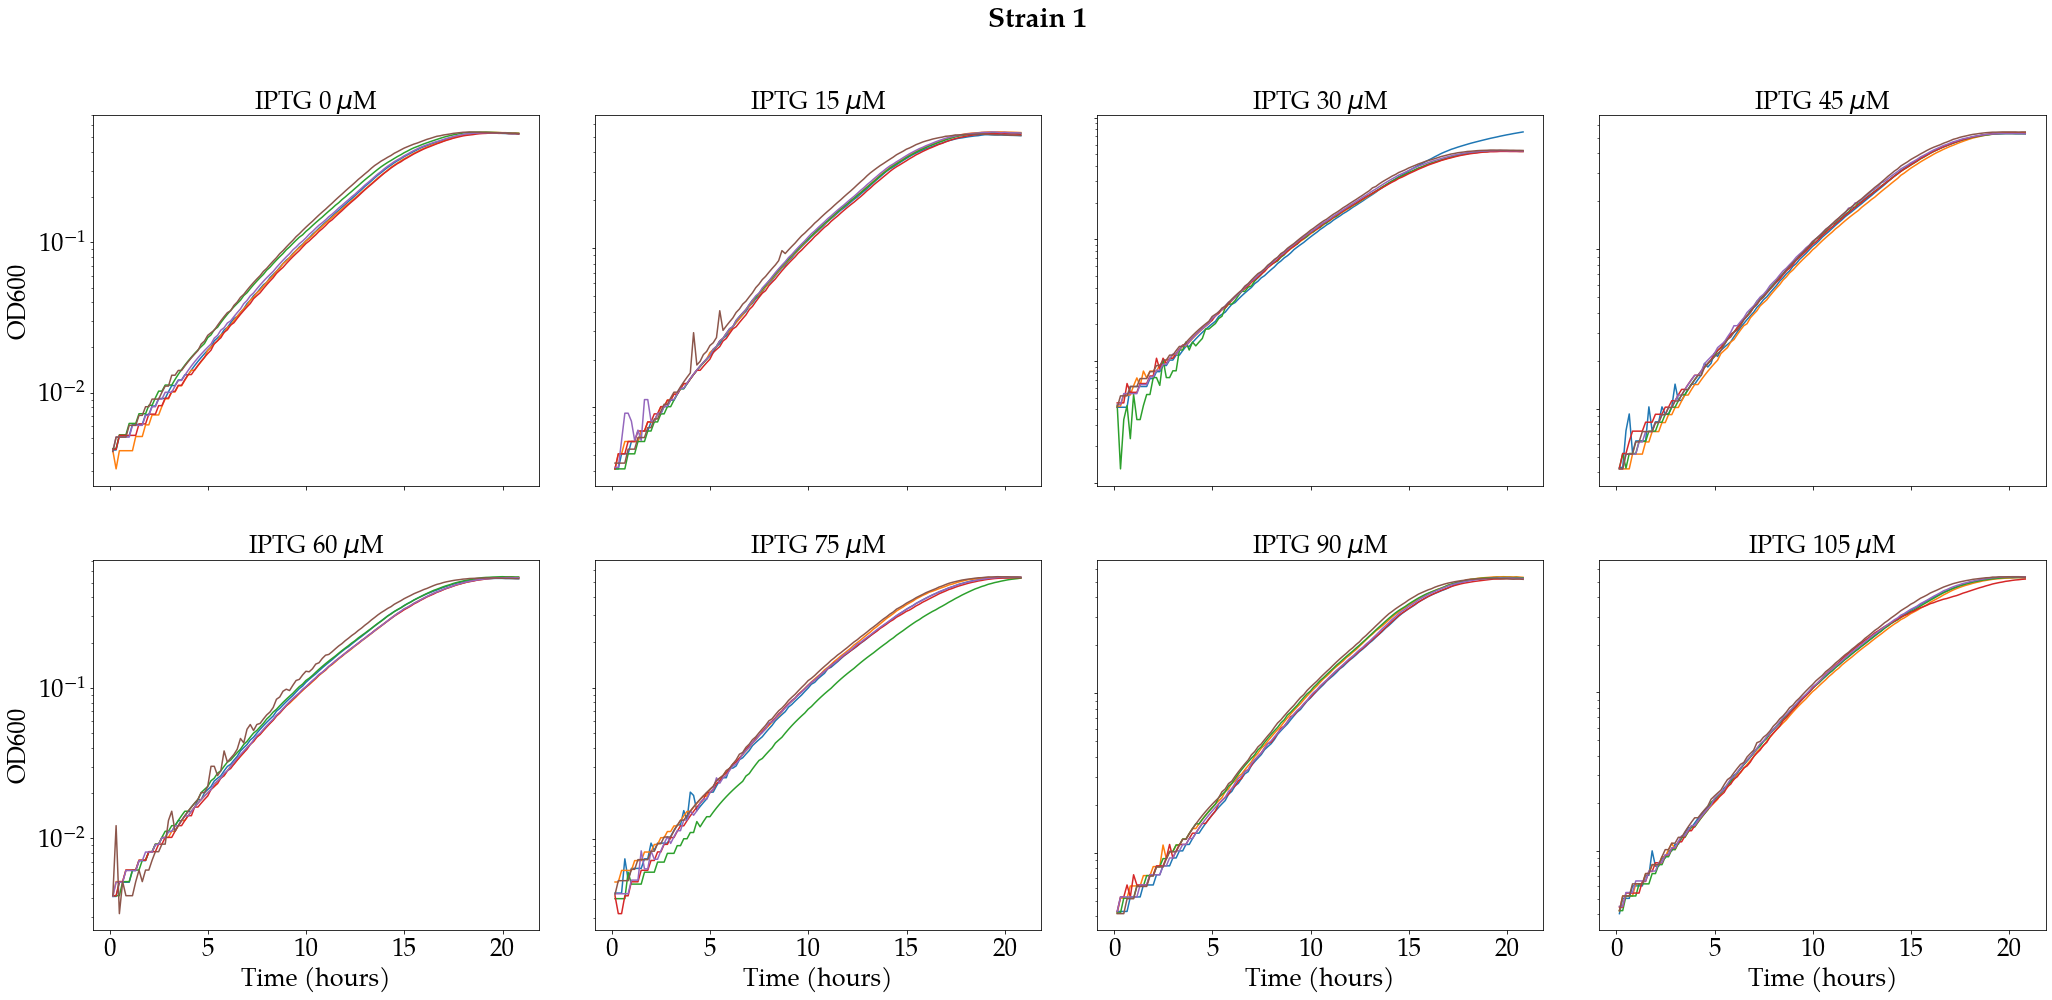

In [8]:
#Plots the data
#Fig S.5
fig = plt.figure(figsize=(35,15))
fig.subplots_adjust(hspace=0.2, wspace=0.125)
fig.suptitle('Strain 1',fontsize=28,fontweight='bold')
for i in range(len(IPTG_concs)):
    subplot = fig.add_subplot(2, 4, i+1)
    subplot.plot(measure_times,curves_strain1[i])
    subplot.set_xlabel('Time (hours)',fontsize=25)
    subplot.set_ylabel('OD600',fontsize=25)
    subplot.set_title('IPTG '+str(IPTG_concs[i])+' '+r'$\mu$'+'M',fontsize=25)
    subplot.set_yscale('log')
    subplot.tick_params(axis='both', labelsize=25)
    subplot.label_outer()
    subplot.tick_params(labelsize=25)
    
plt.show()

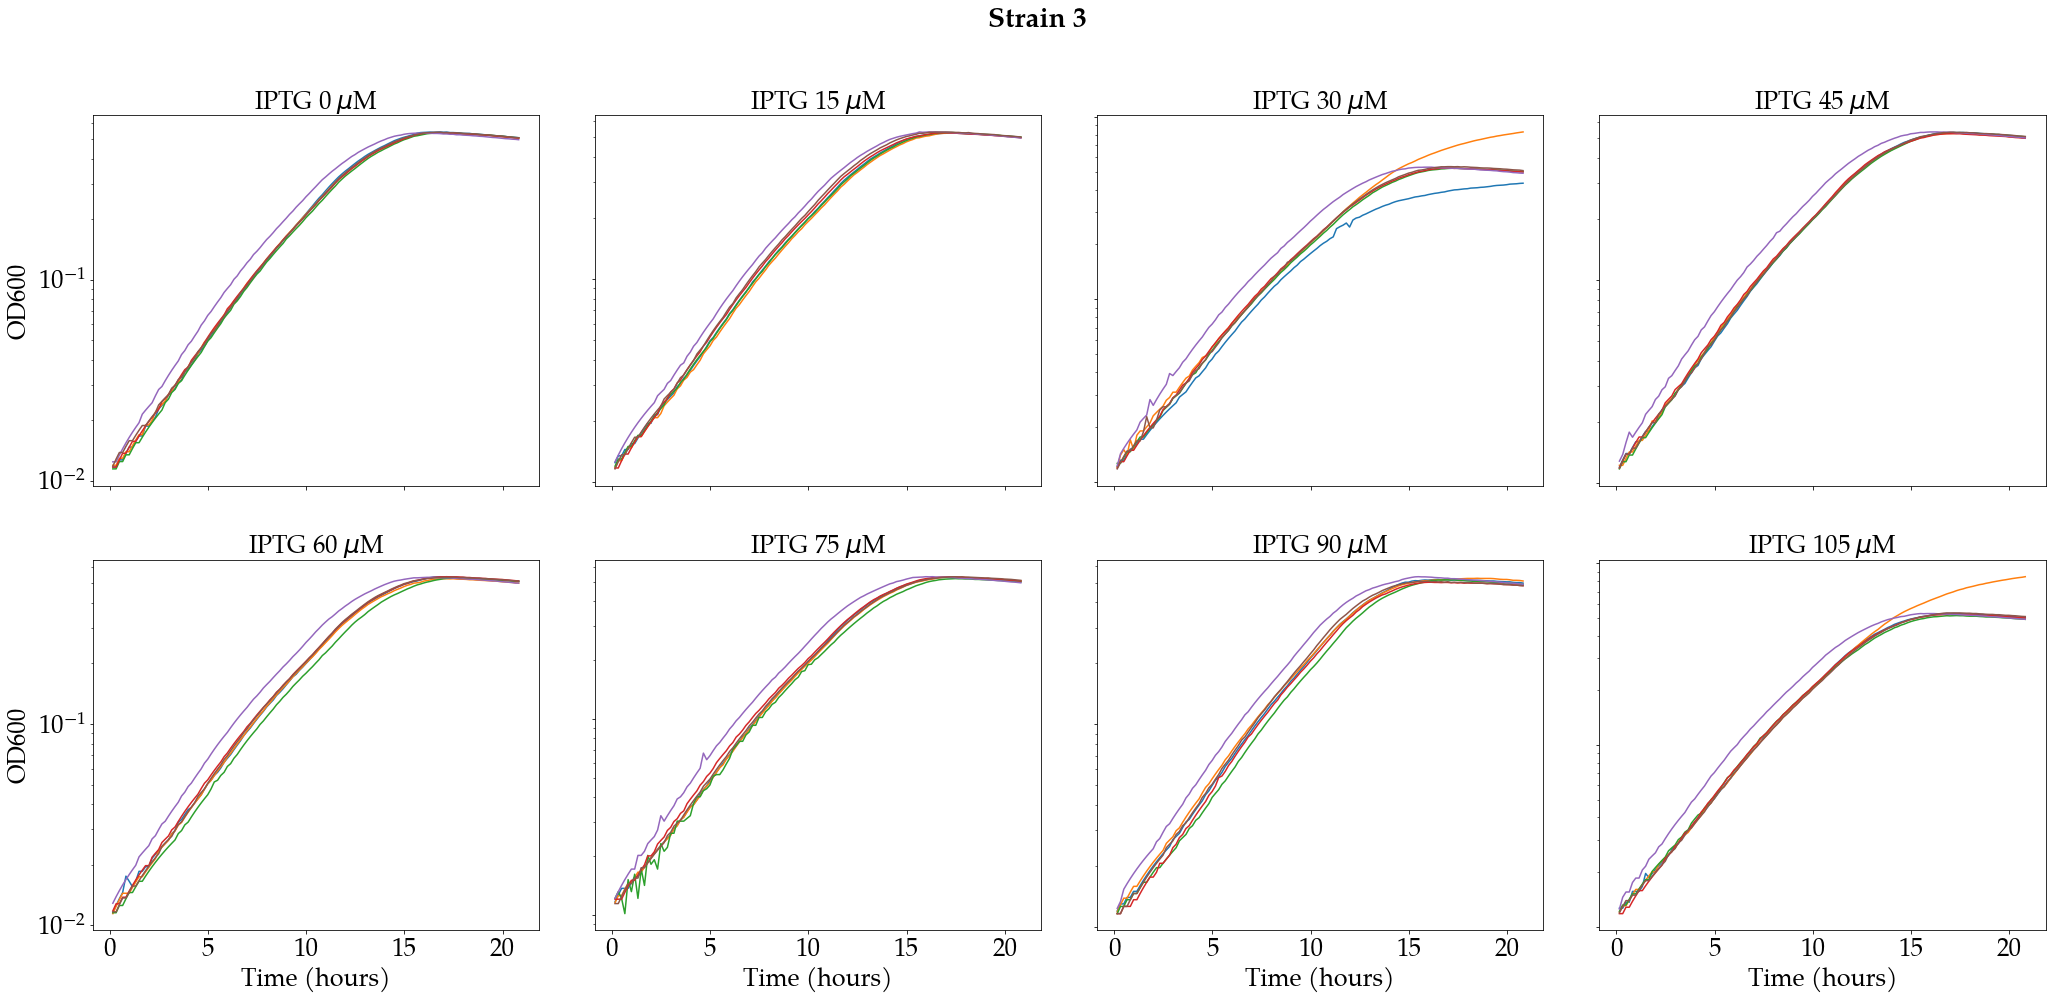

In [9]:
#Figure S.7
fig = plt.figure(figsize=(35,15))
fig.subplots_adjust(hspace=0.2, wspace=0.125)
fig.suptitle('Strain 3',fontsize=28,fontweight='bold')
for i in range(len(IPTG_concs)):
    subplot = fig.add_subplot(2, 4, i+1)
    subplot.plot(measure_times,curves_strain3[i])
    subplot.set_xlabel('Time (hours)',fontsize=25)
    subplot.set_ylabel('OD600',fontsize=25)
    subplot.set_title('IPTG '+str(IPTG_concs[i])+' '+r'$\mu$'+'M',fontsize=25)
    subplot.set_yscale('log')
    subplot.tick_params(axis='both', labelsize=25)
    subplot.label_outer()
    subplot.tick_params(labelsize=25)
    
plt.show()

In [10]:
#Fits the curve to determine the growth rates
strain1_growth_0=[scipy.optimize.curve_fit(lambda t,a,b: a+b*t, measure_times[I:J], np.log(curves_strain1_0.T[i][I:J]))[0][1] for i in range(6)]
strain1_growth_15=[scipy.optimize.curve_fit(lambda t,a,b: a+b*t, measure_times[I:J], np.log(curves_strain1_15.T[i][I:J]))[0][1] for i in range(6)]
strain1_growth_30=[scipy.optimize.curve_fit(lambda t,a,b: a+b*t, measure_times[I:J], np.log(curves_strain1_30.T[i][I:J]))[0][1] for i in range(6)]
strain1_growth_45=[scipy.optimize.curve_fit(lambda t,a,b: a+b*t, measure_times[I:J], np.log(curves_strain1_45.T[i][I:J]))[0][1] for i in range(6)]
strain1_growth_60=[scipy.optimize.curve_fit(lambda t,a,b: a+b*t, measure_times[I:J], np.log(curves_strain1_60.T[i][I:J]))[0][1] for i in range(6)]
strain1_growth_75=[scipy.optimize.curve_fit(lambda t,a,b: a+b*t, measure_times[I:J], np.log(curves_strain1_75.T[i][I:J]))[0][1] for i in range(6)]
strain1_growth_90=[scipy.optimize.curve_fit(lambda t,a,b: a+b*t, measure_times[I:J], np.log(curves_strain1_90.T[i][I:J]))[0][1] for i in range(6)]
strain1_growth_105=[scipy.optimize.curve_fit(lambda t,a,b: a+b*t, measure_times[I:J], np.log(curves_strain1_105.T[i][I:J]))[0][1] for i in range(6)]
strain1_growth_rates=[strain1_growth_0,strain1_growth_15,strain1_growth_30,strain1_growth_45,strain1_growth_60,strain1_growth_75,strain1_growth_90,strain1_growth_105]


strain3_growth_0=[scipy.optimize.curve_fit(lambda t,a,b: a+b*t, measure_times[I:J], np.log(curves_strain3_0.T[i][I:J]))[0][1] for i in range(6)]
strain3_growth_15=[scipy.optimize.curve_fit(lambda t,a,b: a+b*t, measure_times[I:J], np.log(curves_strain3_15.T[i][I:J]))[0][1] for i in range(6)]
strain3_growth_30=[scipy.optimize.curve_fit(lambda t,a,b: a+b*t, measure_times[I:J], np.log(curves_strain3_30.T[i][I:J]))[0][1] for i in range(6)]
strain3_growth_45=[scipy.optimize.curve_fit(lambda t,a,b: a+b*t, measure_times[I:J], np.log(curves_strain3_45.T[i][I:J]))[0][1] for i in range(6)]
strain3_growth_60=[scipy.optimize.curve_fit(lambda t,a,b: a+b*t, measure_times[I:J], np.log(curves_strain3_60.T[i][I:J]))[0][1] for i in range(6)]
strain3_growth_75=[scipy.optimize.curve_fit(lambda t,a,b: a+b*t, measure_times[I:J], np.log(curves_strain3_75.T[i][I:J]))[0][1] for i in range(6)]
strain3_growth_90=[scipy.optimize.curve_fit(lambda t,a,b: a+b*t, measure_times[I:J], np.log(curves_strain3_90.T[i][I:J]))[0][1] for i in range(6)]
strain3_growth_105=[scipy.optimize.curve_fit(lambda t,a,b: a+b*t, measure_times[I:J], np.log(curves_strain3_105.T[i][I:J]))[0][1] for i in range(6)]
strain3_growth_rates=[strain3_growth_0,strain3_growth_15,strain3_growth_30,strain3_growth_45,strain3_growth_60,strain3_growth_75,strain3_growth_90,strain3_growth_105]

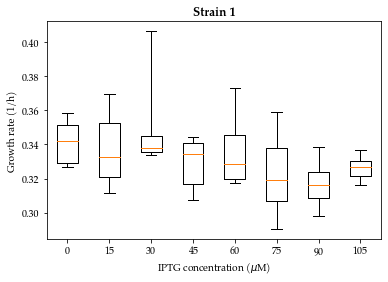

In [11]:
#Makes the boxplots of the results
#Figure S.6
plt.boxplot(strain1_growth_rates,whis=[0,100])
plt.xticks([1,2,3,4,5,6,7,8],IPTG_concs)
plt.title('Strain 1', fontweight='bold')
plt.xlabel('IPTG concentration ('+r'$\mu$'+'M)')
plt.ylabel('Growth rate (1/h)')

plt.show()

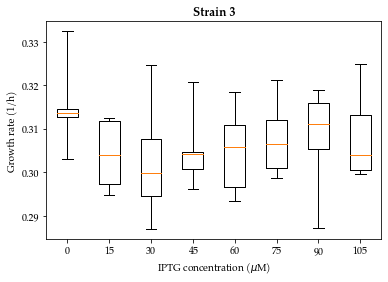

In [12]:
#Figure S.6
plt.boxplot(strain3_growth_rates,whis=[0,100])
plt.xticks([1,2,3,4,5,6,7,8],IPTG_concs)
plt.title('Strain 3', fontweight='bold')
plt.xlabel('IPTG concentration ('+r'$\mu$'+'M)')
plt.ylabel('Growth rate (1/h)')

plt.show()

In [13]:
#Defines the average growth rates of both strains, and their error (as the error of the mean)
g_strain1 = np.array(strain1_growth_rates)[0].mean()
g_strain1_err = np.array(strain1_growth_rates)[0].std()/sqrt(len(strain1_growth_rates[0]))
g_strain3 = np.array(strain3_growth_rates)[0].mean()
g_strain3_err = np.array(strain3_growth_rates)[0].std()/sqrt(len(strain3_growth_rates[0]))

In [14]:
##############################################################################################
### In this part of this notebook we import and analyze data to compute the normalized     ###
### protein production rates (k(C_I)/<I> in the article). This will be necessary to plot   ###
### the data on the experiment (Figure 3 of the article).                                  ###
##############################################################################################

In [15]:
#Imports the data at inoculation
datadir0h='./Experiment data/Day 0'
plate0h=(FCPlate.from_dir(ID='Plate 0h', path=datadir0h, parser='name'))

#Imports the data at 4h and 8h after inoculation
datadir4h='./IPTG calibration/4h'
plate4h=(FCPlate.from_dir(ID='IPTG calibration plate 4h', path=datadir4h, parser='name'))

datadir8h='./IPTG calibration/8h'
plate8h=(FCPlate.from_dir(ID='IPTG calibration plate 8h', path=datadir8h, parser='name'))

#Positions of the two strains, in increasing order ot IPTG concentration
positions_strain1=[['D2','D4','D6','D8','D10','D12'],['B2','B4','B6','B8','B10','B12'],['G2','G4','G6','G8','G10','G12'],['F2','F4','F6','F8','F10','F12'],['C2','C4','C6','C8','C10','C12'],['E2','E4','E6','E8','E10','E12'],['A2','A4','A6','A8','A10','A12'],['H2','H4','H6','H8','H10','H12']];
positions_strain3=[['D1','D3','D5','D7','D9','D11'],['B1','B3','B5','B7','B9','B11'],['G1','G3','G5','G7','G9','G11'],['F1','F3','F5','F7','F9','F11'],['C1','C3','C5','C7','C9','C11'],['E1','E3','E5','E7','E9','E11'],['A1','A3','A5','A7','A9','A11'],['H1','H3','H5','H7','H9','H11']];

In [16]:
#Defines the gates to distinguish the two strains
gate_strain1 = ThresholdGate(1500.0, ['FITC-A'], region='above')
gate_strain3 = ThresholdGate(500.0, ['PE-Texas Red-A'], region='above')


#Defines the gate to distinguish the noise from the data
noise=QuadGate((500,750), ('FITC-A', 'PE-Texas Red-A'), region='bottom left', name='noise') #gate for plate4h and plate8h

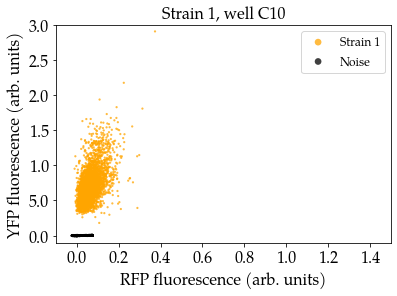

In [17]:
#Comparison between some flow cytometry data and the gates
figure();
cell=random.choice(random.choice(positions_strain1))
plate=plate0h
plate[cell].gate(~noise).gate(gate_strain1).plot(['PE-Texas Red-A','FITC-A'], kind='scatter', color='orange', s=5, alpha=0.75, label='Strain 1');
plate[cell].gate(noise).plot(['PE-Texas Red-A','FITC-A'], kind='scatter', color='black', s=5, alpha=0.75, label='Noise');
plt.xlim([-1000,15000])
plt.xticks([0,2000,4000,6000,8000,10000,12000,14000],labels=['0.0','0.2','0.4','0.6','0.8','1.0','1.2','1.4'],fontsize=16)
plt.yticks([0,5000,10000,15000,20000,25000,30000],labels=['0.0','5.0','1.0','1.5','2.0','2.5','3.0'],fontsize=16)
plt.ylim([-1000,30000])
plt.xlabel('RFP fluorescence (arb. units)', fontsize=16)
plt.ylabel('YFP fluorescence (arb. units)', fontsize=16)
plt.title('Strain 1, well '+cell,fontsize=16)
plt.legend(loc=1, markerscale=3, prop={'size': 12})

plt.show()

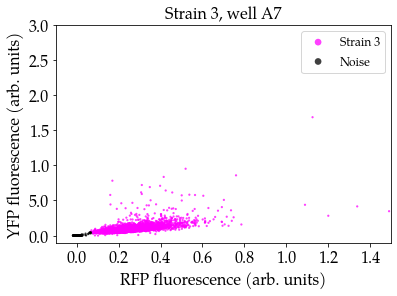

In [18]:
#Comparison between some flow cytometry data and the gates
figure();
cell=random.choice(random.choice(positions_strain3))
plate=plate4h
plate[cell].gate(~noise).gate(gate_strain3).plot(['PE-Texas Red-A','FITC-A'], kind='scatter', color='magenta', s=5, alpha=0.75, label='Strain 3');
plate[cell].gate(noise).plot(['PE-Texas Red-A','FITC-A'], kind='scatter', color='black', s=5, alpha=0.75, label='Noise');
plt.xlim([-1000,15000])
plt.xticks([0,2000,4000,6000,8000,10000,12000,14000],labels=['0.0','0.2','0.4','0.6','0.8','1.0','1.2','1.4'],fontsize=16)
plt.yticks([0,5000,10000,15000,20000,25000,30000],labels=['0.0','5.0','1.0','1.5','2.0','2.5','3.0'],fontsize=16)
plt.ylim([-1000,30000])
plt.xlabel('RFP fluorescence (arb. units)', fontsize=16)
plt.ylabel('YFP fluorescence (arb. units)', fontsize=16)
plt.title('Strain 3, well '+cell,fontsize=16)
plt.legend(loc=1, markerscale=3, prop={'size': 12})

plt.show()

In [19]:
#Computes the fluorescence values for each iteration
strain1_0h=[[(plate0h[i].gate(~noise).gate(gate_strain1))['PE-Texas Red-A'].values.tolist() for i in positions_strain1[j]] for j in range(8)]
strain1_4h=[[(plate4h[i].gate(~noise).gate(gate_strain1))['PE-Texas Red-A'].values.tolist() for i in positions_strain1[j]] for j in range(8)]
strain1_8h=[[(plate8h[i].gate(~noise).gate(gate_strain1))['PE-Texas Red-A'].values.tolist() for i in positions_strain1[j]] for j in range(8)]

strain3_0h=[[(plate0h[i].gate(~noise).gate(gate_strain3))['FITC-A'].values.tolist() for i in positions_strain3[j]] for j in range(8)]
strain3_4h=[[(plate4h[i].gate(~noise).gate(gate_strain3))['FITC-A'].values.tolist() for i in positions_strain3[j]] for j in range(8)]
strain3_8h=[[(plate8h[i].gate(~noise).gate(gate_strain3))['FITC-A'].values.tolist() for i in positions_strain3[j]] for j in range(8)]

In [20]:
#Computes the average value and the error of the fluorescence values
f_strain1_0h=[[mean(strain1_0h[j][i]) for i in range(6)] for j in range(8)]
f_strain1_4h=[[mean(strain1_4h[j][i]) for i in range(6)] for j in range(8)]
f_strain1_8h=[[mean(strain1_8h[j][i]) for i in range(6)] for j in range(8)]

f_strain3_0h=[[mean(strain3_0h[j][i]) for i in range(6)] for j in range(8)]
f_strain3_4h=[[mean(strain3_4h[j][i]) for i in range(6)] for j in range(8)]
f_strain3_8h=[[mean(strain3_8h[j][i]) for i in range(6)] for j in range(8)]

σ_strain1_0h=[[std(strain1_0h[j][i])/sqrt(len(strain1_0h[j][i])) for i in range(6)] for j in range(8)]
σ_strain1_4h=[[std(strain1_4h[j][i])/sqrt(len(strain1_4h[j][i])) for i in range(6)] for j in range(8)]
σ_strain1_8h=[[std(strain1_8h[j][i])/sqrt(len(strain1_8h[j][i])) for i in range(6)] for j in range(8)]

σ_strain3_0h=[[std(strain3_0h[j][i])/sqrt(len(strain3_0h[j][i])) for i in range(6)] for j in range(8)]
σ_strain3_4h=[[std(strain3_4h[j][i])/sqrt(len(strain3_4h[j][i])) for i in range(6)] for j in range(8)]
σ_strain3_8h=[[std(strain3_8h[j][i])/sqrt(len(strain3_8h[j][i])) for i in range(6)] for j in range(8)]

f_strain3_0h_mean=mean(f_strain3_4h[0])
σ_strain3_0h_mean=std(f_strain3_4h[0])
f_strain1_0h_mean=mean(f_strain1_4h[0])
σ_strain1_0h_mean=std(f_strain1_4h[0])

In [21]:
#Defines the average growth rates of both strains, and their error (as the error of the mean)
g_strain1 = np.array(strain1_growth_rates)[0].mean()
g_strain1_err = np.array(strain1_growth_rates)[0].std()/sqrt(len(strain1_growth_rates[0]))
g_strain3 = np.array(strain3_growth_rates)[0].mean()
g_strain3_err = np.array(strain3_growth_rates)[0].std()/sqrt(len(strain3_growth_rates[0]))

In [22]:
#Computes the rescaled protein production rate k(C_I)/<I> for each iteration, with error propagation
k4_strain1=[[-(g_strain1*(2*f_strain1_0h_mean-exp(4*g_strain1)*f_strain1_4h[j][i])/(2*log(2)*(exp(g_strain1*4)-1)))/f_strain1_0h_mean for i in range(6)]  for j in range(8)]
σ_k4_strain1=[[sqrt((exp(g_strain1*4)*g_strain1*f_strain1_4h[j][i]/(f_strain1_0h_mean**2*log(4)*(exp(g_strain1*4)-1)))**2*σ_strain1_0h_mean**2 + (g_strain1*exp(g_strain1*4)/(f_strain1_0h_mean*log(4)*(exp(g_strain1*4)-1)))**2 * σ_strain1_4h[j][i]**2) for i in range(6)]  for j in range(8)]

k4_strain3=[[-(g_strain3*(2*f_strain3_0h_mean-exp(4*g_strain3)*f_strain3_4h[j][i])/(2*log(2)*(exp(g_strain3*4)-1)))/f_strain3_0h_mean for i in range(6)]  for j in range(8)]
σ_k4_strain3=[[sqrt( (exp(g_strain3*4)*g_strain3*f_strain3_4h[j][i]/(f_strain3_0h_mean**2 * log(4) *(exp(g_strain3*4)-1)))**2 * σ_strain3_0h_mean**2 + (g_strain3*exp(g_strain3*4)/(f_strain3_0h_mean*log(4)*(exp(g_strain3*4)-1)))**2 * σ_strain3_4h[j][i]**2) for i in range(6)]  for j in range(8)]

k4_strain1_err_std=[np.std(k4_strain1[j]) for j in range(8)]
k4_strain3_err_std=[np.std(k4_strain3[j]) for j in range(8)]


k8_strain1=[[-(g_strain1*(2*f_strain1_0h_mean-exp(8*g_strain1)*f_strain1_8h[j][i])/(2*log(2)*(exp(g_strain1*8)-1)))/f_strain1_0h_mean for i in range(6)]  for j in range(8)]
σ_k8_strain1=[[sqrt( (exp(g_strain1*8)*g_strain1*f_strain1_8h[j][i]/(f_strain1_0h_mean**2 * log(4) *(exp(g_strain1*8)-1)))**2 * σ_strain1_0h_mean**2 + (g_strain1*exp(g_strain1*8)/(f_strain1_0h_mean*log(4)*(exp(g_strain1*8)-1)))**2 * σ_strain1_8h[j][i]**2) for i in range(6)]  for j in range(8)]

k8_strain3=[[-(g_strain3*(2*f_strain3_0h_mean-exp(8*g_strain3)*f_strain3_8h[j][i])/(2*log(2)*(exp(g_strain3*8)-1)))/f_strain3_0h_mean for i in range(6)]  for j in range(8)]
σ_k8_strain3=[[sqrt( (exp(g_strain3*8)*g_strain3*f_strain3_8h[j][i]/(f_strain3_0h_mean**2 * log(4) *(exp(g_strain3*8)-1)))**2 * σ_strain3_0h_mean**2 + (g_strain3*exp(g_strain3*8)/(f_strain3_0h_mean*log(4)*(exp(g_strain3*8)-1)))**2 * σ_strain3_8h[j][i]**2) for i in range(6)]  for j in range(8)]

In [23]:
#Averages and errors of k(C_I)/<I> for every IPTG concentration at 4h after inoculation
k48_strain1=[[(f_strain1_8h[j][i]-2.0*f_strain1_4h[j][i]*exp(-g_strain1*4.0))/(2.0*log(2.0)/g_strain1*(1.0-exp(-g_strain1*4.0)))/f_strain1_0h_mean for i in range(6)]  for j in range(8)]
σ_k48_strain1=[[sqrt(σ_strain1_4h[j][i]**2/(2.0*log(2.0)/g_strain1*(1.0-exp(-g_strain1*4.0)))**2/f_strain1_0h_mean**2  +  σ_strain1_4h[j][i]**2*4.0*exp(-2.0*g_strain1*4.0)/(2.0*log(2.0)/g_strain1*(1.0-exp(-g_strain1*4.0)))**2/f_strain1_0h_mean**2  +  σ_strain1_0h_mean**2*((f_strain1_8h[j][i]-2.0*f_strain1_4h[j][i]*exp(-g_strain1*4.0))/(2.0*log(2.0)/g_strain1*(1.0-exp(-g_strain1*4.0))))**2/f_strain1_0h_mean**4  +  ((f_strain1_8h[j][i]-2*exp(-g_strain1*4)*f_strain1_4h[j][i])/(2*log(2)*(1.0-exp(-g_strain1*4)))*(1.0-(g_strain1*4*exp(-g_strain1*4))/(1.0-exp(-g_strain1*4)))/f_strain3_0h_mean)**2*g_strain1_err**2)  for i in range(6)] for j in range(8)]

k48_strain3=[[(f_strain3_8h[j][i]-2.0*f_strain3_4h[j][i]*exp(-g_strain3*4.0))/(2.0*log(2.0)/g_strain3*(1.0-exp(-g_strain3*4.0)))/f_strain3_0h_mean for i in range(6)]  for j in range(8)]
σ_k48_strain3=[[sqrt(σ_strain3_4h[j][i]**2/(2.0*log(2.0)/g_strain3*(1.0-exp(-g_strain3*4.0)))**2/f_strain3_0h_mean**2+σ_strain3_4h[j][i]**2*4.0*exp(-2.0*g_strain3*4.0)/(2.0*log(2.0)/g_strain3*(1.0-exp(-g_strain3*4.0)))**2/f_strain3_0h_mean**2+σ_strain3_0h_mean**2*((f_strain3_8h[j][i]-2.0*f_strain3_4h[j][i]*exp(-g_strain3*4.0))/(2.0*log(2.0)/g_strain3*(1.0-exp(-g_strain3*4.0))))**2/f_strain3_0h_mean**4  +  ((f_strain3_8h[j][i]-2*exp(-g_strain3*4)*f_strain3_4h[j][i])/(2*log(2)*(1.0-exp(-g_strain3*4)))*(1.0-(g_strain3*4*exp(-g_strain3*4))/(1.0-exp(-g_strain3*4)))/f_strain3_0h_mean)**2*g_strain3_err**2)  for i in range(6)] for j in range(8)]


k48_strain1_mean=[mean(k48_strain1[j]) for j in range(8)]
k48_strain3_mean=[mean(k48_strain3[j]) for j in range(8)]

k48_strain1_err=[sqrt(mean(np.array(σ_k48_strain1[j])**2)) for j in range(8)]
k48_strain3_err=[sqrt(mean(np.array(σ_k48_strain3[j])**2)) for j in range(8)]

k48_strain1_err=[1.0/len(σ_k48_strain1[j])*sqrt(np.sum(np.power(σ_k48_strain1[j],2))) for j in range(8)]
k48_strain3_err=[1.0/len(σ_k48_strain3[j])*sqrt(np.sum(np.power(σ_k48_strain3[j],2))) for j in range(8)]

In [24]:
##############################################################################################
### In this part of this notebook we import and analyze data relative to the competition   ###
### assays between the strains (1+2 and 3+4)                                               ###
##############################################################################################

In [25]:
#Imports all data
datadir=['./Experiment data/Day 0', './Experiment data/Day 1', './Experiment data/Day 2', './Experiment data/Day 3', './Experiment data/Day 4', './Experiment data/Day 5', './Experiment data/Day 6', './Experiment data/Day 7', './Experiment data/Day 8']
plates_num=len(datadir)

#Time of the measurements (in hours) after the first inoculation
measure_times=np.array(range(plates_num))*24
    
#List containing the complete data of each plate
plate=[]

#Loads all plates
for i in range(plates_num):          
    plate.append(FCPlate.from_dir(ID='Plate +'+str(i), path=datadir[i], parser='name'))

In [26]:
#Defines the gates to distinguish the strains and the noise
gate_strain1 = ThresholdGate(1000, ['FITC-A'], region='above')
gate_strain3 =ThresholdGate(650, ['PE-Texas Red-A'], region='above')

noise_strain1 = QuadGate((1000,650), ('FITC-A', 'PE-Texas Red-A'), region='bottom left', name='noise')
noise_strain3 = QuadGate((2000,850), ('FITC-A', 'PE-Texas Red-A'), region='bottom left', name='noise')

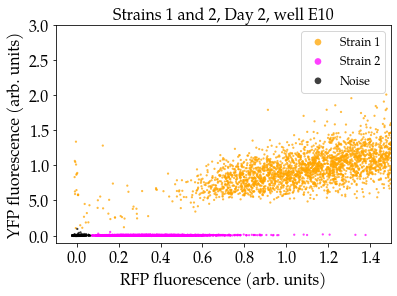

In [27]:
#Comparison between some flow cytometry data and the gates
figure();
cell=random.choice(random.choice(positions_strain1))
day=random.randint(0,8)
plate[day][cell].gate(~noise_strain1).gate(gate_strain1).plot(['PE-Texas Red-A','FITC-A'], kind='scatter', color='orange', s=5, alpha=0.75, label='Strain 1');
plate[day][cell].gate(~noise_strain1).gate(~gate_strain1).plot(['PE-Texas Red-A','FITC-A'], kind='scatter', color='magenta', s=5, alpha=0.75, label='Strain 2');
plate[day][cell].gate(noise_strain1).plot(['PE-Texas Red-A','FITC-A'], kind='scatter', color='black', s=5, alpha=0.75, label='Noise');
plt.xlim([-1000,15000])
plt.xticks([0,2000,4000,6000,8000,10000,12000,14000],labels=['0.0','0.2','0.4','0.6','0.8','1.0','1.2','1.4'],fontsize=16)
plt.yticks([0,5000,10000,15000,20000,25000,30000],labels=['0.0','5.0','1.0','1.5','2.0','2.5','3.0'],fontsize=16)
plt.ylim([-1000,30000])
plt.xlabel('RFP fluorescence (arb. units)', fontsize=16)
plt.ylabel('YFP fluorescence (arb. units)', fontsize=16)
plt.title('Strains 1 and 2, Day '+str(day)+', well '+cell,fontsize=16)
plt.legend(loc=1, markerscale=3, prop={'size': 12})

plt.show()

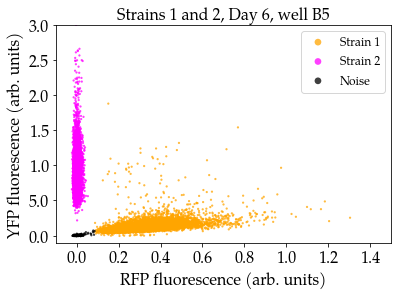

In [28]:
#Comparison between some flow cytometry data and the gates
figure();
cell=random.choice(random.choice(positions_strain3))
day=6
plate[day][cell].gate(~noise_strain3).gate(gate_strain3).plot(['PE-Texas Red-A','FITC-A'], kind='scatter', color='orange', s=5, alpha=0.75, label='Strain 1');
plate[day][cell].gate(~noise_strain3).gate(~gate_strain3).plot(['PE-Texas Red-A','FITC-A'], kind='scatter', color='magenta', s=5, alpha=0.75, label='Strain 2');
plate[day][cell].gate(noise_strain3).plot(['PE-Texas Red-A','FITC-A'], kind='scatter', color='black', s=5, alpha=0.75, label='Noise');
plt.xlim([-1000,15000])
plt.xticks([0,2000,4000,6000,8000,10000,12000,14000],labels=['0.0','0.2','0.4','0.6','0.8','1.0','1.2','1.4'],fontsize=16)
plt.yticks([0,5000,10000,15000,20000,25000,30000],labels=['0.0','5.0','1.0','1.5','2.0','2.5','3.0'],fontsize=16)
plt.ylim([-1000,30000])
plt.xlabel('RFP fluorescence (arb. units)', fontsize=16)
plt.ylabel('YFP fluorescence (arb. units)', fontsize=16)
plt.title('Strains 1 and 2, Day '+str(day)+', well '+cell,fontsize=16)
plt.legend(loc=1, markerscale=3, prop={'size': 12})

plt.show()

In [29]:
#Counts the number of events inside and outside the gate for the assay strain 1+2
gated_strain1=[plate[i].gate(~noise_strain1).gate(gate_strain1).counts().values[:,1::2] for i in range(plates_num)]   #number of ecAG17/19 cells
ungated_strain1=[plate[i].gate(~noise_strain1).gate(~gate_strain1).counts().values[:,1::2] for i in range(plates_num)]  #number of ecAG13 cells

#Counts the number of events inside and outside the gate for the assay strain 3+4
gated_strain3=[plate[i].gate(~noise_strain3).gate(gate_strain3).counts().values[:,0::2] for i in range(plates_num)]     #number of ecAG16/18 cells
ungated_strain3=[plate[i].gate(~noise_strain3).gate(~gate_strain3).counts().values[:,0::2] for i in range(plates_num)]  #number of ecAG11 cells

#Counts the total number of events for the two assays
total_strain1=np.array(gated_strain1)+np.array(ungated_strain1)         #total number of strain 1 cells
total_strain3=np.array(gated_strain3)+np.array(ungated_strain3)         #total number of strain 3 cells

In [30]:
#Computes the relative abundances of the strains in each well
#"R" stands for "relative abundance"
R_strain1=[gated_strain1[i]/total_strain1[i] for i in range(plates_num)]        #relative abundaces of strain 1
R_strain2=[ungated_strain1[i]/total_strain1[i] for i in range(plates_num)]      #relative abundaces of strain 2

R_strain3=[gated_strain3[i]/total_strain3[i] for i in range(plates_num)]        #relative abundaces of strain3
R_strain4=[ungated_strain3[i]/total_strain3[i] for i in range(plates_num)]    #relative abundaces of strain 4

In [31]:
#Orders the data by increasing concentrations of IPTG
rows_order=[3,1,6,5,2,4,0,7]

R_strain3_ord = [[log(R_strain3[i][j]/(1-R_strain3[i][j])) for j in rows_order] for i in range(plates_num)]
R_strain4_ord = [[log(R_strain4[i][j]/(1-R_strain4[i][j])) for j in rows_order] for i in range(plates_num)]

R_strain1_ord = [[log(R_strain1[i][j]/(1-R_strain1[i][j])) for j in rows_order] for i in range(plates_num)]
R_strain2_ord = [[log(R_strain2[i][j]/(1-R_strain2[i][j])) for j in rows_order] for i in range(plates_num)]

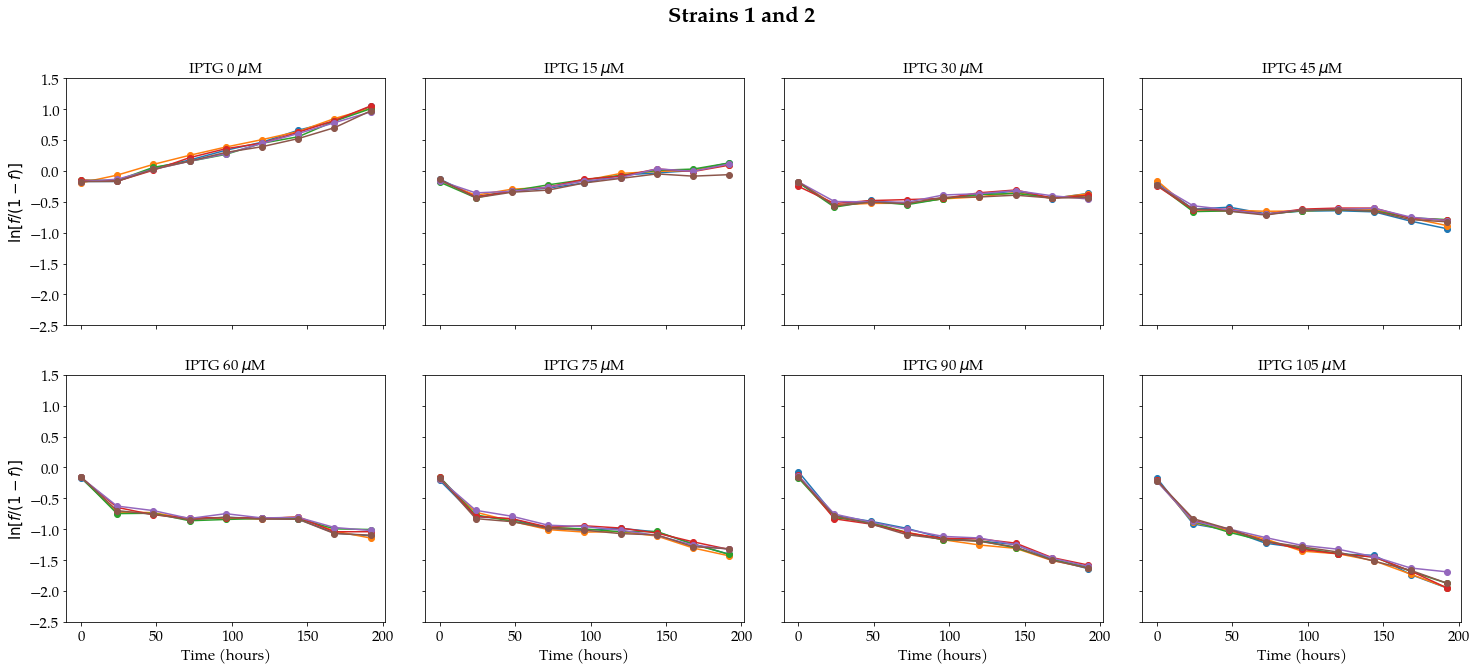

In [32]:
#Computes and plots ln(f/(1-f)) of the strains over time for each IPTG concentration
#Figure S.3
curves_strain1=[np.array([np.array(R_strain1_ord)[i][j] for i in range(plates_num)]).T for j in range(len(IPTG_concs))]

fig2 = plt.figure(figsize=(25,10))
fig2.subplots_adjust(hspace=0.2, wspace=0.125)
fig2.suptitle('Strains 1 and 2', fontweight='bold', fontsize=22)
for i in range(len(IPTG_concs)):
    subplot = fig2.add_subplot(2, 4, i+1)
    subplot.set_ylim(-2.5,1.5)
    subplot.plot(measure_times,curves_strain1[i].T, marker='o')
    subplot.set_xlabel('Time (hours)',fontsize=15)
    subplot.set_ylabel(r'$\ln [f/(1-f)]$',fontsize=15)
    subplot.set_title('IPTG '+str(IPTG_concs[i])+' '+r'$\mu$'+'M',fontsize=15)
    subplot.tick_params(labelsize=15)
    subplot.label_outer()
    
plt.show()

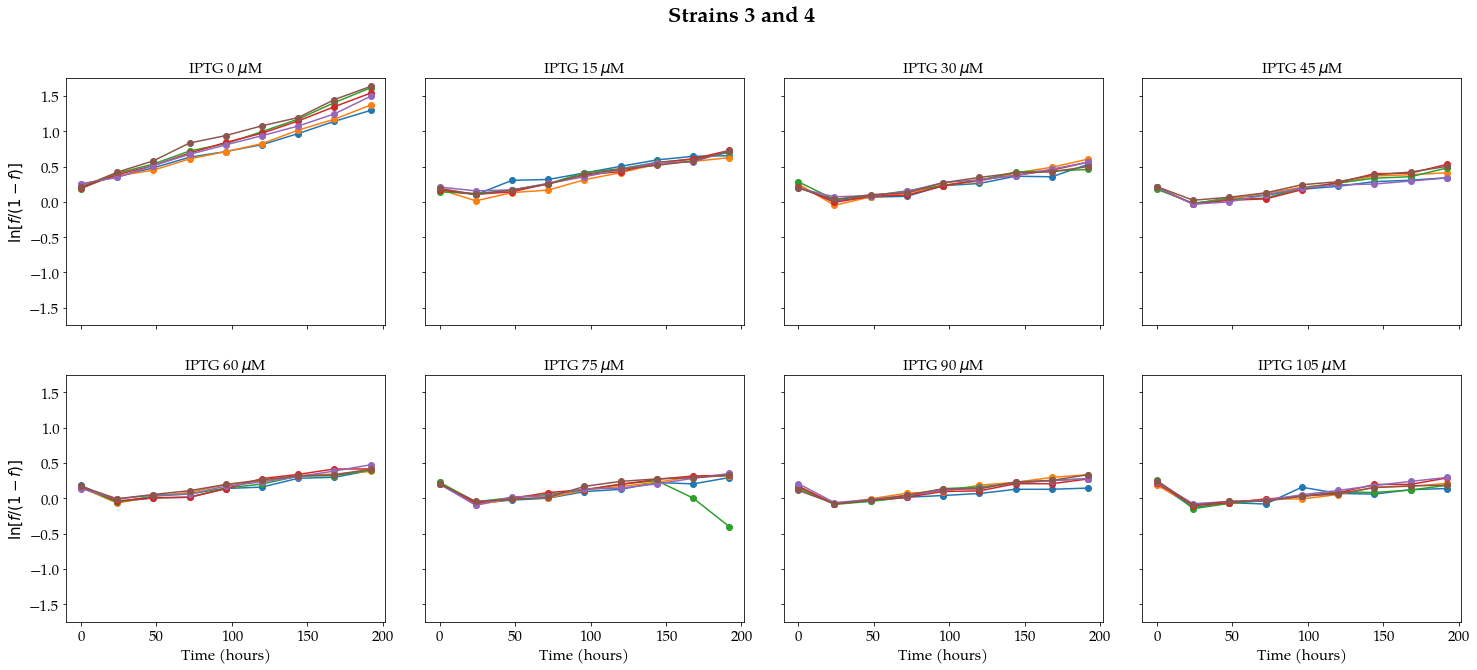

In [33]:
#Figure S4
curves_strain3=[np.array([np.array(R_strain3_ord)[i][j] for i in range(plates_num)]).T for j in range(len(IPTG_concs))]

fig = plt.figure(figsize=(25,10))
fig.subplots_adjust(hspace=0.2, wspace=0.125)
fig.suptitle('Strains 3 and 4', fontweight='bold', fontsize=22)
for i in range(len(IPTG_concs)):
    subplot = fig.add_subplot(2, 4, i+1)
    subplot.set_ylim(-1.75,1.75)
    subplot.plot(measure_times,curves_strain3[i].T, marker='o')
    subplot.set_xlabel('Time (hours)',fontsize=15)
    subplot.set_ylabel(r'$\ln [f/(1-f)]$',fontsize=15)
    subplot.set_title('IPTG '+str(IPTG_concs[i])+' '+r'$\mu$'+'M',fontsize=15)
    subplot.tick_params(labelsize=15)
    subplot.label_outer()
    
plt.show()

In [34]:
#Fits linearly the curves above to determine the strains' selective advantages
fits_strain1=[np.array([scipy.optimize.curve_fit(lambda t,a,b: a+b*t, measure_times[1:6], (curves_strain1[j][i][1:6]))[0][1] for i in range(len(curves_strain1[j]))]) for j in range(len(IPTG_concs))]
fits_strain3=[np.array([scipy.optimize.curve_fit(lambda t,a,b: a+b*t, measure_times[1:6], (curves_strain3[j][i][1:6]))[0][1] for i in range(len(curves_strain3[j]))]) for j in range(len(IPTG_concs))]


#Extracts the fit parameters and their standard deviations
ext_rates_strain1=[mean(fits_strain1[i]) for i in range(len(IPTG_concs))]
ext_rates_strain1_std=[std(fits_strain1[i]) for i in range(len(IPTG_concs))]

ext_rates_strain3=[mean(fits_strain3[i]) for i in range(len(IPTG_concs))]
ext_rates_strain3_std=[std(fits_strain3[i]) for i in range(len(IPTG_concs))]

In [35]:
#Defines the x-values for the plot of the experimental results (Figure 3)
X_strain1=k48_strain1_mean
X_strain3=k48_strain3_mean

In [36]:
#Computes (with a bootstrap approach) the ratios Φ_1/Φ_2 and Φ_3/Φ_4 (eq (44) of the article)
iterations=int(1e4)

ratios1=[[1/(1-random.choice(fits_strain1[j])/random.choice(strain1_growth_rates[j])) for i in range(iterations)] for j in range(8)]
ratios1_mean=[mean(ratios1[i]) for i in range(8)]
ratios1_std=[std(ratios1[i]) for i in range(8)]

ratios3=[[1/(1-random.choice(fits_strain3[j])/random.choice(strain3_growth_rates[j])) for i in range(iterations)] for j in range(8)]
ratios3_mean=[mean(ratios3[i]) for i in range(8)]
ratios3_std=[std(ratios3[i]) for i in range(8)]

In [37]:
#Prepares the data and fits for visualization (for Figure 3)

def func(p, x):
    a, b = p
    return a + b*x

#Model object
lin_model = odr.Model(func)

#Creates a RealData object
data3 = odr.RealData([X_strain3[i] for i in range(1,8)], [np.mean(fits_strain3[i]) for i in range(1,8)], sx=[k4_strain3_err_std[i] for i in range(1,8)], sy=[np.std(fits_strain3[i]) for i in range(1,8)])

#Sets up ODR with the model and data.
odr3 = odr.ODR(data3, lin_model, beta0=[1., 1.])

#Runs the regression.
out3 = odr3.run()

#Prints fit parameters and 1-sigma estimates
popt3 = out3.beta
perr3 = out3.sd_beta
    
#Prepares confidence level curves
nstd3 = 1. # to draw 1-sigma intervals
popt_up3 = popt3 + nstd3 * perr3
popt_dw3 = popt3 - nstd3 * perr3

x_fit3 = np.linspace(min(X_strain3), 1.05*max(X_strain3), 100)
fit3 = func(popt3, x_fit3)
fit_up3 = func(popt_up3, x_fit3)
fit_dw3 = func(popt_dw3, x_fit3)



#Creates a RealData object
data1 = odr.RealData([X_strain1[i] for i in range(1,8)], [np.mean(fits_strain1[i]) for i in range(1,8)], sx=[k4_strain1_err_std[i] for i in range(1,8)], sy=[np.std(fits_strain1[i]) for i in range(1,8)])

#Sets up ODR with the model and data.
odr1 = odr.ODR(data1, lin_model, beta0=[1., 1.])

#Runs the regression.
out1 = odr1.run()

#Prints fit parameters and 1-sigma estimates
popt1 = out1.beta
perr1 = out1.sd_beta

    
#Prepares confidence level curves
nstd1 = 2. # to draw 1-sigma intervals
popt_up1 = popt1 + nstd1 * perr1
popt_dw1 = popt1 - nstd1 * perr1

x_fit1= np.linspace(min(X_strain1), 1.05*max(X_strain1), 100)
fit1 = func(popt1, x_fit1)
fit_up1 = func(popt_up1, x_fit1)
fit_dw1 = func(popt_dw1, x_fit1)



#Ratios - Experiment 1
data_ratio1 = odr.RealData([X_strain1[i] for i in range(1,8)], ratios1_mean[1:8], sx=[k48_strain1_err[i] for i in range(1,8)], sy=[ratios1_std[i] for i in range(1,8)])

#Sets up ODR with the model and data.
odr_ratio1 = odr.ODR(data_ratio1, lin_model, beta0=[1., 1.])

#Runs the regression.
out_ratio1 = odr_ratio1.run()

#Prints fit parameters and 1-sigma estimates
popt_ratio1 = out_ratio1.beta
perr_ratio1 = out_ratio1.sd_beta
    
#Prepares confidence level curves
nstd_ratio1 = 1. # to draw 1-sigma intervals
popt_up_ratio1 = popt_ratio1 + nstd_ratio1 * perr_ratio1
popt_dw_ratio1 = popt_ratio1 - nstd_ratio1 * perr_ratio1

x_fit_ratio1 = np.linspace(min(X_strain1), 1.05*max(X_strain1), 100)
fit_ratio1 = func(popt_ratio1, x_fit_ratio1)
fit_up_ratio1 = func(popt_up_ratio1, x_fit_ratio1)
fit_dw_ratio1 = func(popt_dw_ratio1, x_fit_ratio1)


#Ratios - Experiment 2
data_ratio2 = odr.RealData([X_strain3[i] for i in range(1,8)], ratios3_mean[1:8], sx=[k48_strain3_err[i] for i in range(1,8)], sy=[ratios3_std[i] for i in range(1,8)])

#Sets up ODR with the model and data.
odr_ratio2 = odr.ODR(data_ratio2, lin_model, beta0=[1., 1.])

#Runs the regression.
out_ratio2 = odr_ratio2.run()

#Prints fit parameters and 1-sigma estimates
popt_ratio2 = out_ratio2.beta
perr_ratio2 = out_ratio2.sd_beta
    
#Prepares confidence level curves
nstd_ratio2 = 1. # to draw 1-sigma intervals
popt_up_ratio2 = popt_ratio2 + nstd_ratio2 * perr_ratio1
popt_dw_ratio2 = popt_ratio2 - nstd_ratio2 * perr_ratio1

x_fit_ratio2 = np.linspace(min(X_strain3), 1.05*max(X_strain3), 100)
fit_ratio2 = func(popt_ratio2, x_fit_ratio2)
fit_up_ratio2 = func(popt_up_ratio2, x_fit_ratio2)
fit_dw_ratio2 = func(popt_dw_ratio2, x_fit_ratio2)


font_size=16

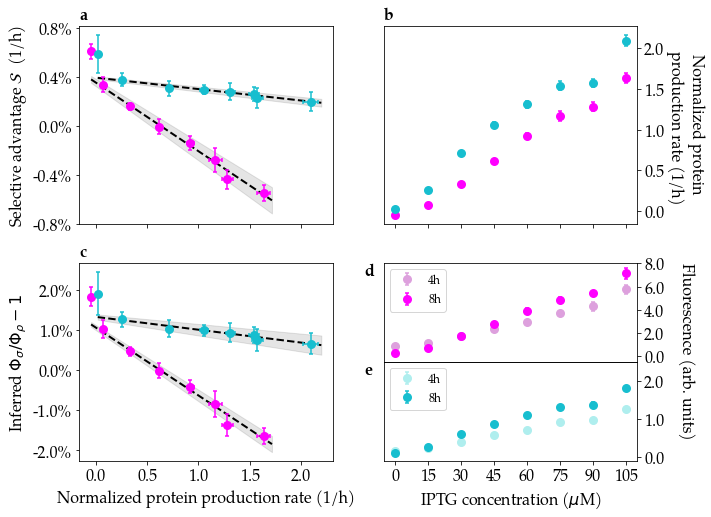

In [38]:
#Plots the experimental results
#Figure 3

fig = plt.figure(figsize=(10,8))

ax1 = fig.add_subplot(221)
ax1.errorbar([X_strain1[i] for i in range(8)],[np.mean(fits_strain1[i]) for i in range(8)], xerr=[2.0*k48_strain1_err[i] for i in range(8)], yerr=[2.0*np.std(fits_strain1[i]) for i in range(8)], color='magenta', fmt='o', zorder=3, ms=7.5, capsize=2, elinewidth=1.5, markeredgewidth=1.5)
ax1.plot(x_fit1, fit1, '--', color='black', lw=2, label='best fit curve',zorder=1)
ax1.fill_between(x_fit1, fit_up1, fit_dw1, alpha=.1, color='k')
ax1.errorbar([X_strain3[i] for i in range(8)],[np.mean(fits_strain3[i]) for i in range(8)], xerr=[2.0*k48_strain3_err[i] for i in range(8)], yerr=[2.0*np.std(fits_strain3[i]) for i in range(8)], color='tab:cyan', fmt='o', zorder=3, ms=7.5, capsize=2, elinewidth=1.5, markeredgewidth=1.5)
ax1.plot(x_fit3, fit3, '--', color='black', lw=2, label='best fit curve',zorder=1)
ax1.fill_between(x_fit3, fit_up3, fit_dw3, alpha=.1, color='k')
ax1.set_xlabel('Normalized protein production rate (1/h)', fontsize=font_size)
ax1.set_ylabel(r'Selective advantage $\mathcal{S}$  (1/h)', fontsize=font_size)
ax1.tick_params(axis='both', labelsize=font_size)
ax1.set_yticks([-0.008,-0.004,0,0.004,0.008])
ax1.set_yticklabels(['-0.8%','-0.4%','0.0%','0.4%','0.8%'])
ax1.set_xticks([0,0.5,1,1.5,2])
ax1.label_outer()
ax1.text(0, 1.1, 'a', transform=ax1.transAxes, fontsize=font_size, fontweight='bold', va='top')

ax2 = fig.add_subplot(222)
ax2.errorbar(IPTG_concs, k48_strain1_mean, yerr=2.0*np.array(k48_strain1_err), fmt='o', color='magenta', ms=7.5, capsize=2, elinewidth=1.5, markeredgewidth=1.5)
ax2.errorbar(IPTG_concs, k48_strain3_mean, yerr=2.0*np.array(k48_strain3_err), fmt='o', color='tab:cyan', ms=7.5, capsize=2, elinewidth=1.5, markeredgewidth=1.5)
ax2.set_xticks(IPTG_concs)
ax2.set_xticklabels([])
ax2.set_ylabel('Normalized protein \n production rate (1/h)', fontsize=font_size, rotation=270, labelpad=40)
ax2.tick_params(axis='both', labelsize=font_size)
ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()
ax2.text(0, 1.1, 'b', transform=ax2.transAxes, fontsize=font_size, fontweight='bold', va='top')

ax3 = fig.add_subplot(223)
ax3.errorbar(X_strain1, ratios1_mean, xerr=[2.0*k48_strain1_err[i] for i in range(8)], yerr=2.0*np.array(ratios1_std), fmt='o', color='magenta', ms=7.5, capsize=2, elinewidth=1.5, markeredgewidth=1.5, zorder=3)
ax3.plot(x_fit_ratio1, fit_ratio1, '--', color='black', lw=2, label='best fit curve',zorder=1)
ax3.fill_between(x_fit_ratio1, fit_up_ratio1, fit_dw_ratio1, alpha=.1, color='k')
ax3.errorbar(X_strain3, ratios3_mean, xerr=[2.0*k48_strain3_err[i] for i in range(8)], yerr=2.0*np.array(ratios3_std), fmt='o', color='tab:cyan', ms=7.5, capsize=2, elinewidth=1.5, markeredgewidth=1.5, zorder=3)
ax3.plot(x_fit_ratio2, fit_ratio2, '--', color='black', lw=2, label='best fit curve',zorder=1)
ax3.fill_between(x_fit_ratio2, fit_up_ratio2, fit_dw_ratio2, alpha=.1, color='k')
ax3.set_xlabel('Normalized protein production rate (1/h)', fontsize=font_size)
ax3.set_xticks([0,0.5,1,1.5,2])
ax3.set_ylabel(r'Inferred $\Phi_\sigma/\Phi_\rho-1$', fontsize=font_size)
ax3.set_yticks([0.980,0.990,1.000,1.010,1.020])
ax3.set_yticklabels(['-2.0%','-1.0%','0.0%','1.0%','2.0%'])
ax3.tick_params(axis='both', labelsize=font_size)
ax3.text(0, 1.1, 'c', transform=ax3.transAxes, fontsize=font_size, fontweight='bold', va='top')


ax4 = fig.add_axes([0.548, 0.1255, 0.352, 0.1715])
map3=ListedColormap(['paleturquoise','tab:cyan'])
color3 =iter(map3(np.linspace(0.25,0.75,2)))
col3= next(color3)
ax4.errorbar(IPTG_concs,np.array(f_strain3_4h).mean(axis=1),yerr=2.0*np.array(f_strain3_4h).std(axis=1), label='4h', color=col3, fmt='o', zorder=2, ms=7.5, capsize=2, elinewidth=1.5, markeredgewidth=1.5)
col3= next(color3)
ax4.errorbar(IPTG_concs,np.array(f_strain3_8h).mean(axis=1),yerr=2.0*np.array(f_strain3_8h).std(axis=1), label='8h', color=col3, fmt='o', zorder=2, ms=7.5, capsize=2, elinewidth=1.5, markeredgewidth=1.5)
ax4.set_xlabel('IPTG concentration ('+r'$\mu$'+'M)', fontsize=font_size)
ax4.set_xticks(IPTG_concs)
ax4.set_ylim([-100,2500])
ax4.set_yticks(np.array([0,1,2])*10e2)
ax4.set_yticklabels([0.0,1.0,2.0])
ax4.tick_params(axis='both', labelsize=font_size)
ax4.legend(loc=2, prop={'size': 12})
ax4.yaxis.set_label_position("right")
ax4.yaxis.tick_right()
ax4.text(-0.075, 1.0, 'e', transform=ax4.transAxes, fontsize=font_size, fontweight='bold', va='top')


ax5 = fig.add_axes([0.548, 0.297, 0.352, 0.1715])
map1=ListedColormap(['plum','magenta'])
color1 =iter(map1(np.linspace(0.25,0.75,2)))
col1= next(color1)
ax5.errorbar(IPTG_concs,np.array(f_strain1_4h).mean(axis=1),yerr=2.0*np.array(f_strain1_4h).std(axis=1), label='4h', color=col1, fmt='o', zorder=2, ms=7.5, capsize=2, elinewidth=1.5, markeredgewidth=1.5)
col1= next(color1)
ax5.errorbar(IPTG_concs,np.array(f_strain1_8h).mean(axis=1),yerr=2.0*np.array(f_strain1_8h).std(axis=1), label='8h', color=col1, fmt='o', zorder=2, ms=7.5, capsize=2, elinewidth=1.5, markeredgewidth=1.5)
ax5.set_xticks([])
ax5.set_ylabel('                   Fluorescence (arb. units)', fontsize=font_size, rotation=270, labelpad=30)
ax5.set_ylim([-500,8000])
ax5.set_yticks(np.array([0,2,4,6,8])*10e2)
ax5.set_yticklabels([0.0,2.0,4.0,6.0,8.0])
ax5.set_xticklabels([])
ax5.tick_params(axis='both', labelsize=font_size)
ax5.legend(loc=2, prop={'size': 12})
ax5.yaxis.set_label_position("right")
ax5.yaxis.tick_right()
ax5.text(-0.075, 1.0, 'd', transform=ax5.transAxes, fontsize=font_size, fontweight='bold', va='top')

plt.show()

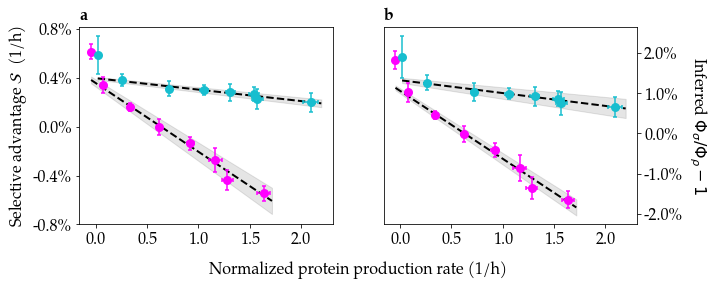

In [39]:
#Plots Figure S.21
fig = plt.figure(figsize=(10,8))

ax1 = fig.add_subplot(221)
ax1.errorbar([X_strain1[i] for i in range(8)],[np.mean(fits_strain1[i]) for i in range(8)], xerr=[2.0*k48_strain1_err[i] for i in range(8)], yerr=[2.0*np.std(fits_strain1[i]) for i in range(8)], color='magenta', fmt='o', zorder=3, ms=7.5, capsize=2, elinewidth=1.5, markeredgewidth=1.5)
ax1.plot(x_fit1, fit1, '--', color='black', lw=2, label='best fit curve',zorder=1)
ax1.fill_between(x_fit1, fit_up1, fit_dw1, alpha=.1, color='k')
ax1.errorbar([X_strain3[i] for i in range(8)],[np.mean(fits_strain3[i]) for i in range(8)], xerr=[2.0*k48_strain3_err[i] for i in range(8)], yerr=[2.0*np.std(fits_strain3[i]) for i in range(8)], color='tab:cyan', fmt='o', zorder=3, ms=7.5, capsize=2, elinewidth=1.5, markeredgewidth=1.5)
ax1.plot(x_fit3, fit3, '--', color='black', lw=2, label='best fit curve',zorder=1)
ax1.fill_between(x_fit3, fit_up3, fit_dw3, alpha=.1, color='k')
ax1.set_xlabel('Normalized protein production rate (1/h)', fontsize=font_size, position=(1.1,0), labelpad=12)
ax1.set_ylabel(r'Selective advantage $\mathcal{S}$  (1/h)', fontsize=font_size)
ax1.tick_params(axis='both', labelsize=font_size)
ax1.set_yticks([-0.008,-0.004,0,0.004,0.008])
ax1.set_yticklabels(['-0.8%','-0.4%','0.0%','0.4%','0.8%'])
ax1.set_xticks([0,0.5,1,1.5,2])
ax1.text(0, 1.1, 'a', transform=ax1.transAxes, fontsize=font_size, fontweight='bold', va='top')


ax3 = fig.add_subplot(222)
ax3.errorbar(X_strain1, ratios1_mean, xerr=[2.0*k48_strain1_err[i] for i in range(8)], yerr=2.0*np.array(ratios1_std), fmt='o', color='magenta', ms=7.5, capsize=2, elinewidth=1.5, markeredgewidth=1.5, zorder=3)
ax3.plot(x_fit_ratio1, fit_ratio1, '--', color='black', lw=2, label='best fit curve',zorder=1)
ax3.fill_between(x_fit_ratio1, fit_up_ratio1, fit_dw_ratio1, alpha=.1, color='k')
ax3.errorbar(X_strain3, ratios3_mean, xerr=[2.0*k48_strain3_err[i] for i in range(8)], yerr=2.0*np.array(ratios3_std), fmt='o', color='tab:cyan', ms=7.5, capsize=2, elinewidth=1.5, markeredgewidth=1.5, zorder=3)
ax3.plot(x_fit_ratio2, fit_ratio2, '--', color='black', lw=2, label='best fit curve',zorder=1)
ax3.fill_between(x_fit_ratio2, fit_up_ratio2, fit_dw_ratio2, alpha=.1, color='k')
ax3.set_xticks([0,0.5,1,1.5,2])
ax3.set_ylabel(r'Inferred $\Phi_\sigma/\Phi_\rho-1$', fontsize=font_size, rotation=270, labelpad=25)
ax3.set_yticks([0.980,0.990,1.000,1.010,1.020])
ax3.set_yticklabels(['-2.0%','-1.0%','0.0%','1.0%','2.0%'])
ax3.tick_params(axis='both', labelsize=font_size)
ax3.yaxis.set_label_position("right")
ax3.yaxis.tick_right()
ax3.text(0, 1.1, 'b', transform=ax3.transAxes, fontsize=font_size, fontweight='bold', va='top')

plt.show()

In [40]:
##############################################################################################
### This part of the notebook imports and alalyzes data to evaluate the relative fitness   ###
### assays (generating figures S.9 to S.20)                                                ###
##############################################################################################

In [41]:
#Imports all data
datadir=['./Relative fitness assays/Day 0', './Relative fitness assays/Day 1', './Relative fitness assays/Day 2', './Relative fitness assays/Day 3', './Relative fitness assays/Day 4', './Relative fitness assays/Day 5']
plates_num=len(datadir)

#Time of the measurements (in hours) after the first inoculation
measure_times=np.array(range(plates_num))*24     
    
#List containing the complete data of each plate
plate=[]


#Loads all plates
for i in range(plates_num):          
    plate.append(FCPlate.from_dir(ID='Plate +'+str(i), path=datadir[i], parser='name'))

#Transforms the data of all plates for analysis
for i in range(plates_num):          
    plate[i] = plate[i].transform('hlog', channels=['FSC-A', 'SSC-A', 'FSC-H', 'SSC-H', 'FITC-A', 'mCherry-A'], b=500.0)

In [42]:
#Defines the gates for each assay. The first number is the assay number, the second one is the strain
gate_1_0R=ThresholdGate(3000, ['mCherry-A'], region='above')
gate_1_noise=PolyGate([(-5e+02, 2.637e+03), (4.336e+01, 2.648e+03), (2.311e+02, 3.013e+03), (3.563e+02, 3.589e+03), (4.188e+02, 4.396e+03), (5.315e+02, 5.491e+03), (5.065e+02, 9.252e+03), (7.503e+03, 9.241e+03), (7.490e+03, 2.250e+03), (1.746e+03, 2.272e+03), (1.733e+03, -2e+03), (-5e+02, -2e+03), (-5e+02, -2e+03)], ('FITC-A', 'mCherry-A'), region='in', name='gate_1_noise')

gate_2_4=ThresholdGate(2500, ['FITC-A'], region='above')
gate_2_noise=PolyGate([(-5e+02, 2.637e+03), (4.336e+01, 2.648e+03), (2.311e+02, 3.013e+03), (3.563e+02, 3.589e+03), (4.188e+02, 4.396e+03), (5.315e+02, 5.491e+03), (5.065e+02, 9.252e+03), (7.503e+03, 9.241e+03), (7.490e+03, 2.250e+03), (1.746e+03, 2.272e+03), (1.733e+03, -2e+03), (-5e+02, -2e+03), (-5e+02, -2e+03)], ('FITC-A', 'mCherry-A'), region='in', name='gate_2_noise')

gate_3_0R=ThresholdGate(3000, ['mCherry-A'], region='above')
gate_3_noise=PolyGate([(-5e+02, 2.637e+03), (4.336e+01, 2.648e+03), (2.311e+02, 3.013e+03), (3.563e+02, 3.589e+03), (4.188e+02, 4.396e+03), (5.315e+02, 5.491e+03), (5.065e+02, 9.252e+03), (7.503e+03, 9.241e+03), (7.490e+03, 2.250e+03), (1.746e+03, 2.272e+03), (1.733e+03, -2e+03), (-5e+02, -2e+03), (-5e+02, -2e+03)], ('FITC-A', 'mCherry-A'), region='in', name='gate_3_noise')

gate_4_0Y=ThresholdGate(2500, ['FITC-A'], region='above')
gate_4_noise=PolyGate([(-5e+02, 2.637e+03), (4.336e+01, 2.648e+03), (2.311e+02, 3.013e+03), (3.563e+02, 3.589e+03), (4.188e+02, 4.396e+03), (5.315e+02, 5.491e+03), (5.065e+02, 9.252e+03), (7.503e+03, 9.241e+03), (7.490e+03, 2.250e+03), (1.746e+03, 2.272e+03), (1.733e+03, -2e+03), (-5e+02, -2e+03), (-5e+02, -2e+03)], ('FITC-A', 'mCherry-A'), region='in', name='gate_4_noise')

gate_5_1=ThresholdGate(2000, ['FITC-A'], region='above')
gate_5_noise=PolyGate([(-5e+02, 2.821e+03), (-2.282e+01, 2.821e+03), (1.714e+02, 3.249e+03), (4.433e+02, 5.497e+03), (1.920e+03, 7.780e+03), (2.942e+03, 7.851e+03), (3.176e+03, 7.411e+03), (3.188e+03, 5.711e+03), (2.178e+03, 3.986e+03), (1.544e+03, 1.097e+03), (1.156e+03, -2e+03), (-5e+02, -1.162e+03), (-5e+02, 2e+03)], ('FITC-A', 'mCherry-A'), region='in', name='gate_5_noise')

gate_6_3=ThresholdGate(3000, ['mCherry-A'], region='above')
gate_6_noise=QuadGate((1000, 3000), ('FITC-A', 'mCherry-A'), region='bottom left', name='gate_6_noise')

In [43]:
#Counts the number of events for every strain in every assay, for every IPTG concentrations
counts_1_0R_0IPTG=[plate[i].gate(~gate_1_noise).gate(gate_1_0R).counts().values[4,6:12] for i in range(plates_num)]
counts_1_0R_105IPTG=[plate[i].gate(~gate_1_noise).gate(gate_1_0R).counts().values[0,0:6] for i in range(plates_num)] 
counts_1_0Y_0IPTG=[plate[i].gate(~gate_1_noise).gate(~gate_1_0R).counts().values[4,6:12] for i in range(plates_num)]
counts_1_0Y_105IPTG=[plate[i].gate(~gate_1_noise).gate(~gate_1_0R).counts().values[0,0:6] for i in range(plates_num)]

counts_2_4_0IPTG=[plate[i].gate(~gate_2_noise).gate(gate_2_4).counts().values[0,6:12] for i in range(plates_num)]
counts_2_4_105IPTG=[plate[i].gate(~gate_2_noise).gate(gate_2_4).counts().values[6,0:6] for i in range(plates_num)]
counts_2_2_0IPTG=[plate[i].gate(~gate_2_noise).gate(~gate_2_4).counts().values[0,6:12] for i in range(plates_num)]
counts_2_2_105IPTG=[plate[i].gate(~gate_2_noise).gate(~gate_2_4).counts().values[6,0:6] for i in range(plates_num)]

counts_3_0R_0IPTG=[plate[i].gate(~gate_3_noise).gate(gate_3_0R).counts().values[2,0:6] for i in range(plates_num)]
counts_3_0R_105IPTG=[plate[i].gate(~gate_3_noise).gate(gate_3_0R).counts().values[7,6:12] for i in range(plates_num)]
counts_3_4_0IPTG=[plate[i].gate(~gate_3_noise).gate(~gate_3_0R).counts().values[2,0:6] for i in range(plates_num)]
counts_3_4_105IPTG=[plate[i].gate(~gate_3_noise).gate(~gate_3_0R).counts().values[7,6:12] for i in range(plates_num)]

counts_4_0Y_0IPTG=[plate[i].gate(~gate_4_noise).gate(gate_4_0Y).counts().values[2,6:12] for i in range(plates_num)]
counts_4_0Y_105IPTG=[plate[i].gate(~gate_4_noise).gate(gate_4_0Y).counts().values[1,0:6] for i in range(plates_num)]
counts_4_2_0IPTG=[plate[i].gate(~gate_4_noise).gate(~gate_4_0Y).counts().values[2,6:12] for i in range(plates_num)]
counts_4_2_105IPTG=[plate[i].gate(~gate_4_noise).gate(~gate_4_0Y).counts().values[1,0:6] for i in range(plates_num)]

counts_5_0R_0IPTG=[plate[i].gate(~gate_5_noise).gate(~gate_5_1).counts().values[5,6:12] for i in range(plates_num)]
counts_5_1_0IPTG=[plate[i].gate(~gate_5_noise).gate(gate_5_1).counts().values[5,6:12] for i in range(plates_num)]
counts_5_0R_30IPTG=[plate[i].gate(~gate_5_noise).gate(~gate_5_1).counts().values[7,0:6] for i in range(plates_num)]
counts_5_1_30IPTG=[plate[i].gate(~gate_5_noise).gate(gate_5_1).counts().values[7,0:6] for i in range(plates_num)]
counts_5_0R_75IPTG=[plate[i].gate(~gate_5_noise).gate(~gate_5_1).counts().values[4,0:6] for i in range(plates_num)]
counts_5_1_75IPTG=[plate[i].gate(~gate_5_noise).gate(gate_5_1).counts().values[4,0:6] for i in range(plates_num)]
counts_5_0R_105IPTG=[plate[i].gate(~gate_5_noise).gate(~gate_5_1).counts().values[1,6:12] for i in range(plates_num)]
counts_5_1_105IPTG=[plate[i].gate(~gate_5_noise).gate(gate_5_1).counts().values[1,6:12] for i in range(plates_num)]

counts_6_0Y_0IPTG=[plate[i].gate(~gate_6_noise).gate(~gate_6_3).counts().values[5,0:6] for i in range(plates_num)]
counts_6_3_0IPTG=[plate[i].gate(~gate_6_noise).gate(gate_6_3).counts().values[5,0:6] for i in range(plates_num)]
counts_6_0Y_30IPTG=[plate[i].gate(~gate_6_noise).gate(~gate_6_3).counts().values[3,6:12] for i in range(plates_num)]
counts_6_3_30IPTG=[plate[i].gate(~gate_6_noise).gate(gate_6_3).counts().values[3,6:12] for i in range(plates_num)]
counts_6_0Y_75IPTG=[plate[i].gate(~gate_6_noise).gate(~gate_6_3).counts().values[6,6:12] for i in range(plates_num)]
counts_6_3_75IPTG=[plate[i].gate(~gate_6_noise).gate(gate_6_3).counts().values[6,6:12] for i in range(plates_num)]
counts_6_0Y_105IPTG=[plate[i].gate(~gate_6_noise).gate(~gate_6_3).counts().values[3,0:6] for i in range(plates_num)]
counts_6_3_105IPTG=[plate[i].gate(~gate_6_noise).gate(gate_6_3).counts().values[3,0:6] for i in range(plates_num)]

In [44]:
#Computes the total events in each assay
total_1_0IPTG=np.array(counts_1_0R_0IPTG)+np.array(counts_1_0Y_0IPTG)
total_1_105IPTG=np.array(counts_1_0R_105IPTG)+np.array(counts_1_0Y_105IPTG)

total_2_0IPTG=np.array(counts_2_4_0IPTG)+np.array(counts_2_2_0IPTG)
total_2_105IPTG=np.array(counts_2_4_105IPTG)+np.array(counts_2_2_105IPTG)

total_3_0IPTG=np.array(counts_3_0R_0IPTG)+np.array(counts_3_4_0IPTG)
total_3_105IPTG=np.array(counts_3_0R_105IPTG)+np.array(counts_3_4_105IPTG)

total_4_0IPTG=np.array(counts_4_0Y_0IPTG)+np.array(counts_4_2_0IPTG)
total_4_105IPTG=np.array(counts_4_0Y_105IPTG)+np.array(counts_4_2_105IPTG)

total_5_0IPTG=np.array(counts_5_0R_0IPTG)+np.array(counts_5_1_0IPTG)
total_5_30IPTG=np.array(counts_5_0R_30IPTG)+np.array(counts_5_1_30IPTG)
total_5_75IPTG=np.array(counts_5_0R_75IPTG)+np.array(counts_5_1_75IPTG)
total_5_105IPTG=np.array(counts_5_0R_105IPTG)+np.array(counts_5_1_105IPTG)

total_6_0IPTG=np.array(counts_6_0Y_0IPTG)+np.array(counts_6_3_0IPTG)
total_6_30IPTG=np.array(counts_6_0Y_30IPTG)+np.array(counts_6_3_30IPTG)
total_6_75IPTG=np.array(counts_6_0Y_75IPTG)+np.array(counts_6_3_75IPTG)
total_6_105IPTG=np.array(counts_6_0Y_105IPTG)+np.array(counts_6_3_105IPTG)

In [45]:
#Computes the relative abundances for each strain, assay and IPTG concentration
relab_1_0R_0IPTG=np.array(counts_1_0R_0IPTG)/total_1_0IPTG
relab_1_0Y_0IPTG=np.array(counts_1_0Y_0IPTG)/total_1_0IPTG
relab_1_0R_105IPTG=np.array(counts_1_0R_105IPTG)/total_1_105IPTG
relab_1_0Y_105IPTG=np.array(counts_1_0Y_105IPTG)/total_1_105IPTG

relab_2_4_0IPTG=np.array(counts_2_4_0IPTG)/total_2_0IPTG
relab_2_2_0IPTG=np.array(counts_2_2_0IPTG)/total_2_0IPTG
relab_2_4_105IPTG=np.array(counts_2_4_105IPTG)/total_2_105IPTG
relab_2_2_105IPTG=np.array(counts_2_2_105IPTG)/total_2_105IPTG

relab_3_0R_0IPTG=np.array(counts_3_0R_0IPTG)/total_3_0IPTG
relab_3_4_0IPTG=np.array(counts_3_4_0IPTG)/total_3_0IPTG
relab_3_0R_105IPTG=np.array(counts_3_0R_105IPTG)/total_3_105IPTG
relab_3_4_105IPTG=np.array(counts_3_4_105IPTG)/total_3_105IPTG

relab_4_0Y_0IPTG=np.array(counts_4_0Y_0IPTG)/total_4_0IPTG
relab_4_2_0IPTG=np.array(counts_4_2_0IPTG)/total_4_0IPTG
relab_4_0Y_105IPTG=np.array(counts_4_0Y_105IPTG)/total_4_105IPTG
relab_4_2_105IPTG=np.array(counts_4_2_105IPTG)/total_4_105IPTG

relab_5_0R_0IPTG=np.array(counts_5_0R_0IPTG)/total_5_0IPTG
relab_5_1_0IPTG=np.array(counts_5_1_0IPTG)/total_5_0IPTG
relab_5_0R_30IPTG=np.array(counts_5_0R_30IPTG)/total_5_30IPTG
relab_5_1_30IPTG=np.array(counts_5_1_30IPTG)/total_5_30IPTG
relab_5_0R_75IPTG=np.array(counts_5_0R_75IPTG)/total_5_75IPTG
relab_5_1_75IPTG=np.array(counts_5_1_75IPTG)/total_5_75IPTG
relab_5_0R_105IPTG=np.array(counts_5_0R_105IPTG)/total_5_105IPTG
relab_5_1_105IPTG=np.array(counts_5_1_105IPTG)/total_5_105IPTG

relab_6_0Y_0IPTG=np.array(counts_6_0Y_0IPTG)/total_6_0IPTG
relab_6_3_0IPTG=np.array(counts_6_3_0IPTG)/total_6_0IPTG
relab_6_0Y_30IPTG=np.array(counts_6_0Y_30IPTG)/total_6_30IPTG
relab_6_3_30IPTG=np.array(counts_6_3_30IPTG)/total_6_30IPTG
relab_6_0Y_75IPTG=np.array(counts_6_0Y_75IPTG)/total_6_75IPTG
relab_6_3_75IPTG=np.array(counts_6_3_75IPTG)/total_6_75IPTG
relab_6_0Y_105IPTG=np.array(counts_6_0Y_105IPTG)/total_6_105IPTG
relab_6_3_105IPTG=np.array(counts_6_3_105IPTG)/total_6_105IPTG

In [46]:
#Computes the growth rate for every strain, assay and IPTG concentration
growth_rates_1_0R_0IPTG=[scipy.optimize.curve_fit(lambda t,a,b: a+b*t, measure_times, np.log(relab_1_0R_0IPTG.T[i]))[0][1] for i in range(6)]
growth_rates_1_0R_105IPTG=[scipy.optimize.curve_fit(lambda t,a,b: a+b*t, measure_times, np.log(relab_1_0R_105IPTG.T[i]))[0][1] for i in range(6)]
growth_rates_1_0Y_0IPTG=[scipy.optimize.curve_fit(lambda t,a,b: a+b*t, measure_times, np.log(relab_1_0Y_0IPTG.T[i]))[0][1] for i in range(6)]
growth_rates_1_0Y_105IPTG=[scipy.optimize.curve_fit(lambda t,a,b: a+b*t, measure_times, np.log(relab_1_0Y_105IPTG.T[i]))[0][1] for i in range(6)]

growth_rates_2_4_0IPTG=[scipy.optimize.curve_fit(lambda t,a,b: a+b*t, measure_times, np.log(relab_2_4_0IPTG.T[i]))[0][1] for i in range(6)]
growth_rates_2_4_105IPTG=[scipy.optimize.curve_fit(lambda t,a,b: a+b*t, measure_times, np.log(relab_2_4_105IPTG.T[i]))[0][1] for i in range(6)]
growth_rates_2_2_0IPTG=[scipy.optimize.curve_fit(lambda t,a,b: a+b*t, measure_times, np.log(relab_2_2_0IPTG.T[i]))[0][1] for i in range(6)]
growth_rates_2_2_105IPTG=[scipy.optimize.curve_fit(lambda t,a,b: a+b*t, measure_times, np.log(relab_2_2_105IPTG.T[i]))[0][1] for i in range(6)]

growth_rates_3_0R_0IPTG=[scipy.optimize.curve_fit(lambda t,a,b: a+b*t, measure_times, np.log(relab_3_0R_0IPTG.T[i]))[0][1] for i in range(6)]
growth_rates_3_0R_105IPTG=[scipy.optimize.curve_fit(lambda t,a,b: a+b*t, measure_times, np.log(relab_3_0R_105IPTG.T[i]))[0][1] for i in range(6)]
growth_rates_3_4_0IPTG=[scipy.optimize.curve_fit(lambda t,a,b: a+b*t, measure_times, np.log(relab_3_4_0IPTG.T[i]))[0][1] for i in range(6)]
growth_rates_3_4_105IPTG=[scipy.optimize.curve_fit(lambda t,a,b: a+b*t, measure_times, np.log(relab_3_4_105IPTG.T[i]))[0][1] for i in range(6)]

growth_rates_4_0Y_0IPTG=[scipy.optimize.curve_fit(lambda t,a,b: a+b*t, measure_times, np.log(relab_4_0Y_0IPTG.T[i]))[0][1] for i in range(6)]
growth_rates_4_0Y_105IPTG=[scipy.optimize.curve_fit(lambda t,a,b: a+b*t, measure_times, np.log(relab_4_0Y_105IPTG.T[i]))[0][1] for i in range(6)]
growth_rates_4_2_0IPTG=[scipy.optimize.curve_fit(lambda t,a,b: a+b*t, measure_times, np.log(relab_4_2_0IPTG.T[i]))[0][1] for i in range(6)]
growth_rates_4_2_105IPTG=[scipy.optimize.curve_fit(lambda t,a,b: a+b*t, measure_times, np.log(relab_4_2_105IPTG.T[i]))[0][1] for i in range(6)]

growth_rates_5_0R_0IPTG=[scipy.optimize.curve_fit(lambda t,a,b: a+b*t, measure_times, np.log(relab_5_0R_0IPTG.T[i]))[0][1] for i in range(6)]
growth_rates_5_0R_30IPTG=[scipy.optimize.curve_fit(lambda t,a,b: a+b*t, measure_times, np.log(relab_5_0R_30IPTG.T[i]))[0][1] for i in range(6)]
growth_rates_5_0R_75IPTG=[scipy.optimize.curve_fit(lambda t,a,b: a+b*t, measure_times, np.log(relab_5_0R_75IPTG.T[i]))[0][1] for i in range(6)]
growth_rates_5_0R_105IPTG=[scipy.optimize.curve_fit(lambda t,a,b: a+b*t, measure_times, np.log(relab_5_0R_105IPTG.T[i]))[0][1] for i in range(6)]
growth_rates_5_1_0IPTG=[scipy.optimize.curve_fit(lambda t,a,b: a+b*t, measure_times, np.log(relab_5_1_0IPTG.T[i]))[0][1] for i in range(6)]
growth_rates_5_1_30IPTG=[scipy.optimize.curve_fit(lambda t,a,b: a+b*t, measure_times, np.log(relab_5_1_30IPTG.T[i]))[0][1] for i in range(6)]
growth_rates_5_1_75IPTG=[scipy.optimize.curve_fit(lambda t,a,b: a+b*t, measure_times, np.log(relab_5_1_75IPTG.T[i]))[0][1] for i in range(6)]
growth_rates_5_1_105IPTG=[scipy.optimize.curve_fit(lambda t,a,b: a+b*t, measure_times, np.log(relab_5_1_105IPTG.T[i]))[0][1] for i in range(6)]

growth_rates_6_0Y_0IPTG=[scipy.optimize.curve_fit(lambda t,a,b: a+b*t, measure_times, np.log(relab_6_0Y_0IPTG.T[i]))[0][1] for i in range(6)]
growth_rates_6_0Y_30IPTG=[scipy.optimize.curve_fit(lambda t,a,b: a+b*t, measure_times, np.log(relab_6_0Y_30IPTG.T[i]))[0][1] for i in range(6)]
growth_rates_6_0Y_75IPTG=[scipy.optimize.curve_fit(lambda t,a,b: a+b*t, measure_times, np.log(relab_6_0Y_75IPTG.T[i]))[0][1] for i in range(6)]
growth_rates_6_0Y_105IPTG=[scipy.optimize.curve_fit(lambda t,a,b: a+b*t, measure_times, np.log(relab_6_0Y_105IPTG.T[i]))[0][1] for i in range(6)]
growth_rates_6_3_0IPTG=[scipy.optimize.curve_fit(lambda t,a,b: a+b*t, measure_times, np.log(relab_6_3_0IPTG.T[i]))[0][1] for i in range(6)]
growth_rates_6_3_30IPTG=[scipy.optimize.curve_fit(lambda t,a,b: a+b*t, measure_times, np.log(relab_6_3_30IPTG.T[i]))[0][1] for i in range(6)]
growth_rates_6_3_75IPTG=[scipy.optimize.curve_fit(lambda t,a,b: a+b*t, measure_times, np.log(relab_6_3_75IPTG.T[i]))[0][1] for i in range(6)]
growth_rates_6_3_105IPTG=[scipy.optimize.curve_fit(lambda t,a,b: a+b*t, measure_times, np.log(relab_6_3_105IPTG.T[i]))[0][1] for i in range(6)]

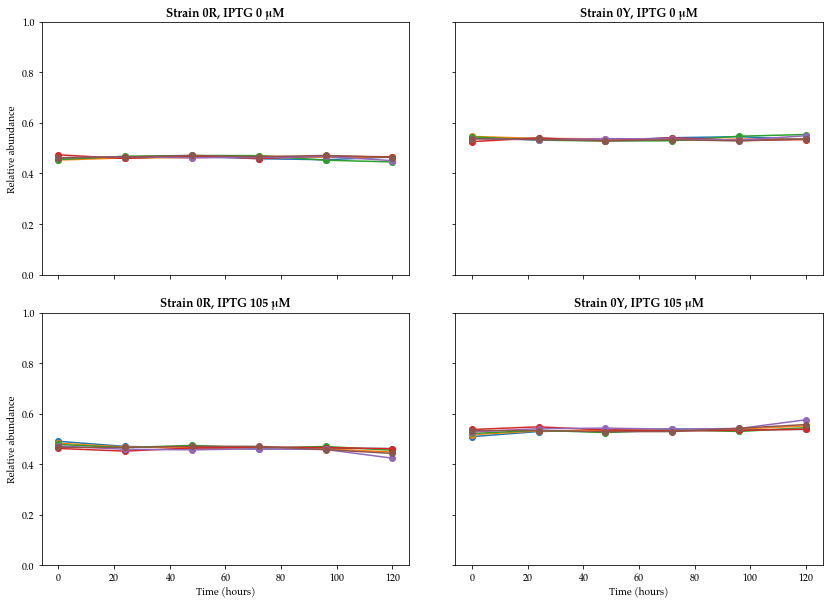

In [47]:
#Plot Figures S.9
fig = plt.figure(figsize=(14,10))
fig.subplots_adjust(hspace=0.15, wspace=0.125)

subplot = fig.add_subplot(2, 2, 0+1)
subplot.set_ylim(0,1)
subplot.plot(measure_times,relab_1_0R_0IPTG, marker='o')
subplot.set_xlabel('Time (hours)')
subplot.set_ylabel('Relative abundance')
subplot.set_title('Strain 0R, IPTG 0 μM', fontweight='bold')
subplot.label_outer()

subplot = fig.add_subplot(2, 2, 1+1)
subplot.set_ylim(0,1)
subplot.plot(measure_times,relab_1_0Y_0IPTG, marker='o')
subplot.set_xlabel('Time (hours)')
subplot.set_ylabel('Relative abundance')
subplot.set_title('Strain 0Y, IPTG 0 μM', fontweight='bold')
subplot.label_outer()

subplot = fig.add_subplot(2, 2, 2+1)
subplot.set_ylim(0,1)
subplot.plot(measure_times,relab_1_0R_105IPTG, marker='o')
subplot.set_xlabel('Time (hours)')
subplot.set_ylabel('Relative abundance')
subplot.set_title('Strain 0R, IPTG 105 μM', fontweight='bold')
subplot.label_outer()

subplot = fig.add_subplot(2, 2, 3+1)
subplot.set_ylim(0,1)
subplot.plot(measure_times,relab_1_0Y_105IPTG, marker='o')
subplot.set_xlabel('Time (hours)')
subplot.set_ylabel('Relative abundance')
subplot.set_title('Strain 0Y, IPTG 105 μM', fontweight='bold')
subplot.label_outer()

plt.show()

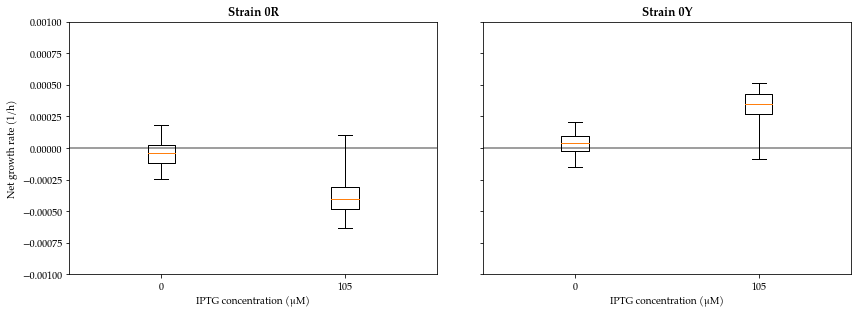

In [48]:
#Plots Figure S.10
fig = plt.figure(figsize=(14,10))
fig.subplots_adjust(hspace=0.15, wspace=0.125)

subplot = fig.add_subplot(2, 2, 0+1)
subplot.boxplot([growth_rates_1_0R_0IPTG,growth_rates_1_0R_105IPTG],whis=[0,100])
subplot.set_title('Strain 0R', fontweight='bold')
subplot.set_xlabel('IPTG concentration (μM)')
subplot.set_ylabel('Net growth rate (1/h)')
subplot.set_xticks([1,2])
subplot.set_xticklabels(['0','105'])
subplot.set_ylim([-0.001,0.001])
subplot.axhline(0,color='k',alpha=0.5)

subplot = fig.add_subplot(2, 2, 1+1)
subplot.boxplot([growth_rates_1_0Y_0IPTG,growth_rates_1_0Y_105IPTG],whis=[0,100])
subplot.set_title('Strain 0Y', fontweight='bold')
subplot.set_xlabel('IPTG concentration (μM)')
subplot.set_xticks([1,2])
subplot.set_xticklabels(['0','105'])
subplot.set_ylim([-0.001,0.001])
subplot.set_yticklabels([])
subplot.axhline(0,color='k',alpha=0.5)

plt.show()

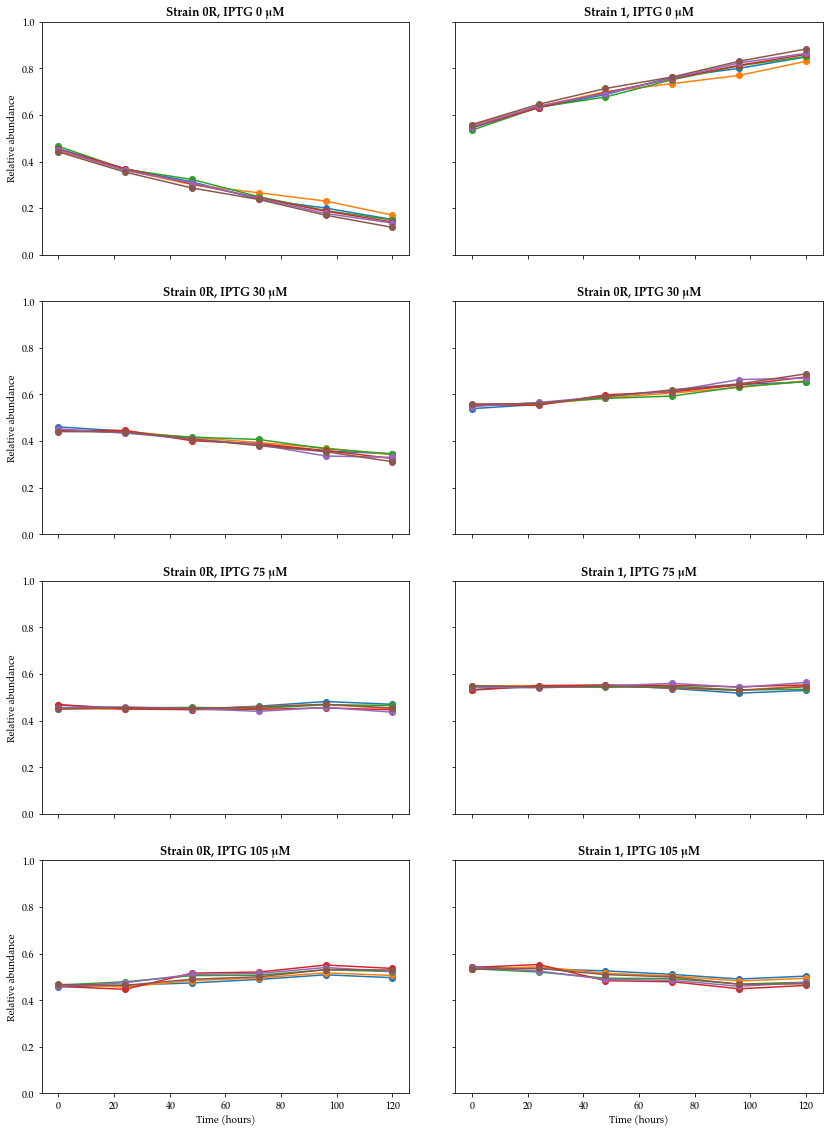

In [49]:
#Plot Figure S.11
fig = plt.figure(figsize=(14,30))
fig.subplots_adjust(hspace=0.2, wspace=0.125)

subplot = fig.add_subplot(6, 2, 0+1)
subplot.set_ylim(0,1)
subplot.plot(measure_times,relab_5_0R_0IPTG, marker='o')
subplot.set_xlabel('Time (hours)')
subplot.set_ylabel('Relative abundance')
subplot.set_title('Strain 0R, IPTG 0 μM', fontweight='bold')
subplot.label_outer()

subplot = fig.add_subplot(6, 2, 1+1)
subplot.set_ylim(0,1)
subplot.plot(measure_times,relab_5_1_0IPTG, marker='o')
subplot.set_xlabel('Time (hours)')
subplot.set_ylabel('Relative abundance')
subplot.set_title('Strain 1, IPTG 0 μM', fontweight='bold')
subplot.label_outer()

subplot = fig.add_subplot(6, 2, 2+1)
subplot.set_ylim(0,1)
subplot.plot(measure_times,relab_5_0R_30IPTG, marker='o')
subplot.set_xlabel('Time (hours)')
subplot.set_ylabel('Relative abundance')
subplot.set_title('Strain 0R, IPTG 30 μM', fontweight='bold')
subplot.label_outer()

subplot = fig.add_subplot(6, 2, 3+1)
subplot.set_ylim(0,1)
subplot.plot(measure_times,relab_5_1_30IPTG, marker='o')
subplot.set_xlabel('Time (hours)')
subplot.set_ylabel('Relative abundance')
subplot.set_title('Strain 0R, IPTG 30 μM', fontweight='bold')
subplot.label_outer()

subplot = fig.add_subplot(6, 2, 4+1)
subplot.set_ylim(0,1)
subplot.plot(measure_times,relab_5_0R_75IPTG, marker='o')
subplot.set_xlabel('Time (hours)')
subplot.set_ylabel('Relative abundance')
subplot.set_title('Strain 0R, IPTG 75 μM', fontweight='bold')
subplot.label_outer()

subplot = fig.add_subplot(6, 2, 5+1)
subplot.set_ylim(0,1)
subplot.plot(measure_times,relab_5_1_75IPTG, marker='o')
subplot.set_xlabel('Time (hours)')
subplot.set_ylabel('Relative abundance')
subplot.set_title('Strain 1, IPTG 75 μM', fontweight='bold')
subplot.label_outer()

subplot = fig.add_subplot(6, 2, 6+1)
subplot.set_ylim(0,1)
subplot.plot(measure_times,relab_5_0R_105IPTG, marker='o')
subplot.set_xlabel('Time (hours)')
subplot.set_ylabel('Relative abundance')
subplot.set_title('Strain 0R, IPTG 105 μM', fontweight='bold')

subplot = fig.add_subplot(6, 2, 7+1)
subplot.set_ylim(0,1)
subplot.plot(measure_times,relab_5_1_105IPTG, marker='o')
subplot.set_xlabel('Time (hours)')
subplot.set_title('Strain 1, IPTG 105 μM', fontweight='bold')
subplot.set_yticklabels([],visible=False)

plt.show()

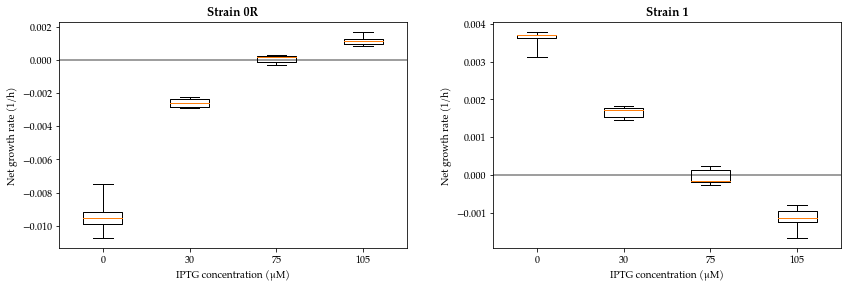

In [50]:
#Plot Figure S.12
fig = plt.figure(figsize=(14,10))
fig.subplots_adjust(hspace=0.4, wspace=0.25)

subplot = fig.add_subplot(2, 2, 0+1)
subplot.boxplot([growth_rates_5_0R_0IPTG,growth_rates_5_0R_30IPTG,growth_rates_5_0R_75IPTG,growth_rates_5_0R_105IPTG],whis=[0,100])
subplot.set_title('Strain 0R', fontweight='bold')
subplot.set_xlabel('IPTG concentration (μM)')
subplot.set_ylabel('Net growth rate (1/h)')
subplot.set_xticks([1,2,3,4])
subplot.set_xticklabels(['0','30','75','105'])
subplot.axhline(0,color='k',alpha=0.5)


subplot = fig.add_subplot(2, 2, 1+1)
subplot.boxplot([growth_rates_5_1_0IPTG,growth_rates_5_1_30IPTG,growth_rates_5_1_75IPTG,growth_rates_5_1_105IPTG],whis=[0,100])
subplot.set_title('Strain 1', fontweight='bold')
subplot.set_xlabel('IPTG concentration (μM)')
subplot.set_ylabel('Net growth rate (1/h)')
subplot.set_xticks([1,2,3,4])
subplot.set_xticklabels(['0','30','75','105'])
subplot.axhline(0,color='k',alpha=0.5)

plt.show()

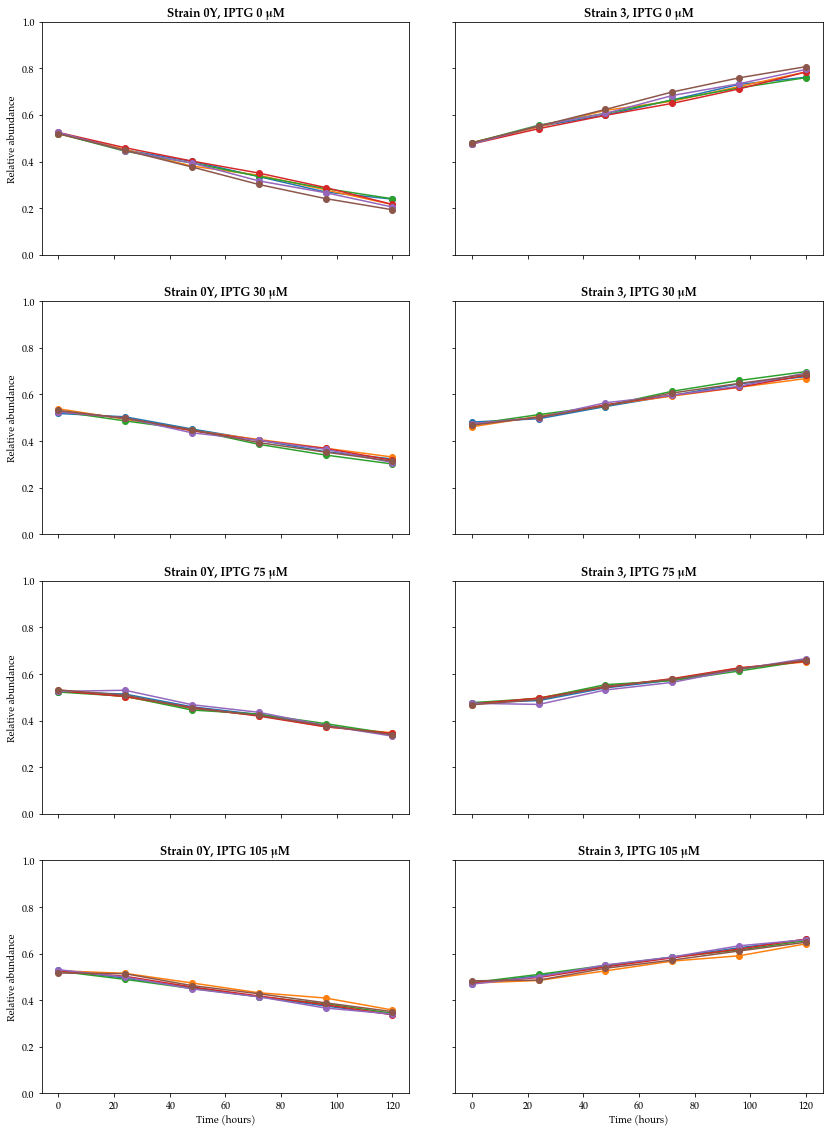

In [51]:
#Plot Figure S.13
fig = plt.figure(figsize=(14,30))
fig.subplots_adjust(hspace=0.2, wspace=0.125)

subplot = fig.add_subplot(6, 2, 0+1)
subplot.set_ylim(0,1)
subplot.plot(measure_times,relab_6_0Y_0IPTG, marker='o')
subplot.set_xlabel('Time (hours)')
subplot.set_ylabel('Relative abundance')
subplot.set_title('Strain 0Y, IPTG 0 μM', fontweight='bold')
subplot.label_outer()

subplot = fig.add_subplot(6, 2, 1+1)
subplot.set_ylim(0,1)
subplot.plot(measure_times,relab_6_3_0IPTG, marker='o')
subplot.set_xlabel('Time (hours)')
subplot.set_ylabel('Relative abundance')
subplot.set_title('Strain 3, IPTG 0 μM', fontweight='bold')
subplot.label_outer()

subplot = fig.add_subplot(6, 2, 2+1)
subplot.set_ylim(0,1)
subplot.plot(measure_times,relab_6_0Y_30IPTG, marker='o')
subplot.set_xlabel('Time (hours)')
subplot.set_ylabel('Relative abundance')
subplot.set_title('Strain 0Y, IPTG 30 μM', fontweight='bold')
subplot.label_outer()

subplot = fig.add_subplot(6, 2, 3+1)
subplot.set_ylim(0,1)
subplot.plot(measure_times,relab_6_3_30IPTG, marker='o')
subplot.set_xlabel('Time (hours)')
subplot.set_ylabel('Relative abundance')
subplot.set_title('Strain 3, IPTG 30 μM', fontweight='bold')
subplot.label_outer()

subplot = fig.add_subplot(6, 2, 4+1)
subplot.set_ylim(0,1)
subplot.plot(measure_times,relab_6_0Y_75IPTG, marker='o')
subplot.set_xlabel('Time (hours)')
subplot.set_ylabel('Relative abundance')
subplot.set_title('Strain 0Y, IPTG 75 μM', fontweight='bold')
subplot.label_outer()

subplot = fig.add_subplot(6, 2, 5+1)
subplot.set_ylim(0,1)
subplot.plot(measure_times,relab_6_3_75IPTG, marker='o')
subplot.set_xlabel('Time (hours)')
subplot.set_ylabel('Relative abundance')
subplot.set_title('Strain 3, IPTG 75 μM', fontweight='bold')
subplot.label_outer()

subplot = fig.add_subplot(6, 2, 6+1)
subplot.set_ylim(0,1)
subplot.plot(measure_times,relab_6_0Y_105IPTG, marker='o')
subplot.set_xlabel('Time (hours)')
subplot.set_ylabel('Relative abundance')
subplot.set_title('Strain 0Y, IPTG 105 μM', fontweight='bold')

subplot = fig.add_subplot(6, 2, 7+1)
subplot.set_ylim(0,1)
subplot.plot(measure_times,relab_6_3_105IPTG, marker='o')
subplot.set_xlabel('Time (hours)')
subplot.set_title('Strain 3, IPTG 105 μM', fontweight='bold')
subplot.set_yticklabels([],visible=False)


plt.show()

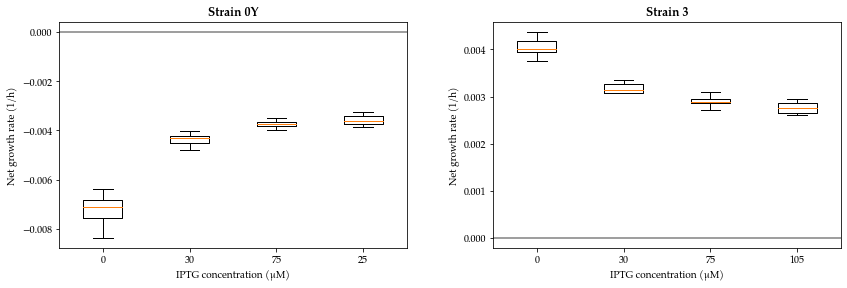

In [52]:
#Plots Figure S.14
fig = plt.figure(figsize=(14,10))
fig.subplots_adjust(hspace=0.4, wspace=0.25)

subplot = fig.add_subplot(2, 2, 0+1)
subplot.boxplot([growth_rates_6_0Y_0IPTG,growth_rates_6_0Y_30IPTG,growth_rates_6_0Y_75IPTG,growth_rates_6_0Y_105IPTG],whis=[0,100])
subplot.set_title('Strain 0Y', fontweight='bold')
subplot.set_xlabel('IPTG concentration (μM)')
subplot.set_ylabel('Net growth rate (1/h)')
subplot.set_xticks([1,2,3,4])
subplot.set_xticklabels(['0','30','75','25','105'])
subplot.axhline(0,color='k',alpha=0.5)


subplot = fig.add_subplot(2, 2, 1+1)
subplot.boxplot([growth_rates_6_3_0IPTG,growth_rates_6_3_30IPTG,growth_rates_6_3_75IPTG,growth_rates_6_3_105IPTG],whis=[0,100])
subplot.set_title('Strain 3', fontweight='bold')
subplot.set_xlabel('IPTG concentration (μM)')
subplot.set_ylabel('Net growth rate (1/h)')
subplot.set_xticks([1,2,3,4])
subplot.set_xticklabels(['0','30','75','105'])
subplot.axhline(0,color='k',alpha=0.5)

plt.show()

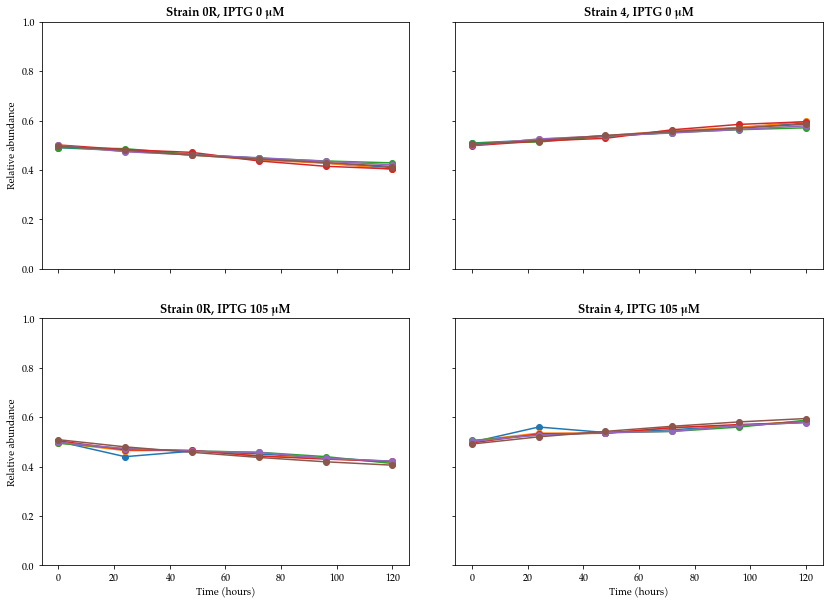

In [53]:
#Plots Figure S.15
fig = plt.figure(figsize=(14,10))
fig.subplots_adjust(hspace=0.2, wspace=0.125)

subplot = fig.add_subplot(2, 2, 0+1)
subplot.set_ylim(0,1)
subplot.plot(measure_times,relab_3_0R_0IPTG,marker='o')
subplot.set_xlabel('Time (hours)')
subplot.set_ylabel('Relative abundance')
subplot.set_title('Strain 0R, IPTG 0 μM', fontweight='bold')
subplot.label_outer()

subplot = fig.add_subplot(2, 2, 1+1)
subplot.set_ylim(0,1)
subplot.plot(measure_times,relab_3_4_0IPTG,marker='o')
subplot.set_xlabel('Time (hours)')
subplot.set_ylabel('Relative abundance')
subplot.set_title('Strain 4, IPTG 0 μM', fontweight='bold')
subplot.label_outer()

subplot = fig.add_subplot(2, 2, 2+1)
subplot.set_ylim(0,1)
subplot.plot(measure_times,relab_3_0R_105IPTG,marker='o')
subplot.set_xlabel('Time (hours)')
subplot.set_ylabel('Relative abundance')
subplot.set_title('Strain 0R, IPTG 105 μM', fontweight='bold')
subplot.label_outer()

subplot = fig.add_subplot(2, 2, 3+1)
subplot.set_ylim(0,1)
subplot.plot(measure_times,relab_3_4_105IPTG,marker='o')
subplot.set_xlabel('Time (hours)')
subplot.set_ylabel('Relative abundance')
subplot.set_title('Strain 4, IPTG 105 μM', fontweight='bold')
subplot.label_outer()

plt.show()

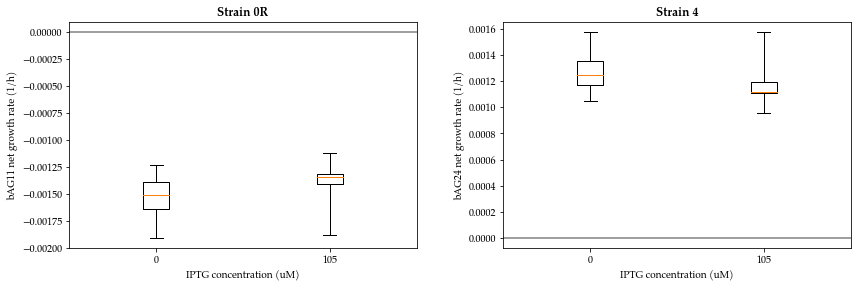

In [54]:
#Plots Figure S.16
fig = plt.figure(figsize=(14,10))
fig.subplots_adjust(hspace=0.4, wspace=0.25)

subplot = fig.add_subplot(2, 2, 0+1)
subplot.boxplot([growth_rates_3_0R_0IPTG,growth_rates_3_0R_105IPTG],whis=[0,100])
subplot.set_title('Strain 0R', fontweight='bold')
subplot.set_xlabel('IPTG concentration (uM)')
subplot.set_ylabel('bAG11 net growth rate (1/h)')
subplot.set_xticks([1,2])
subplot.set_xticklabels(['0','105'])
subplot.axhline(0,color='k',alpha=0.5)

subplot = fig.add_subplot(2, 2, 1+1)
subplot.boxplot([growth_rates_3_4_0IPTG,growth_rates_3_4_105IPTG],whis=[0,100])
subplot.set_title('Strain 4', fontweight='bold')
subplot.set_xlabel('IPTG concentration (uM)')
subplot.set_ylabel('bAG24 net growth rate (1/h)')
subplot.set_xticks([1,2])
subplot.set_xticklabels(['0','105'])
subplot.axhline(0,color='k',alpha=0.5)

plt.show()

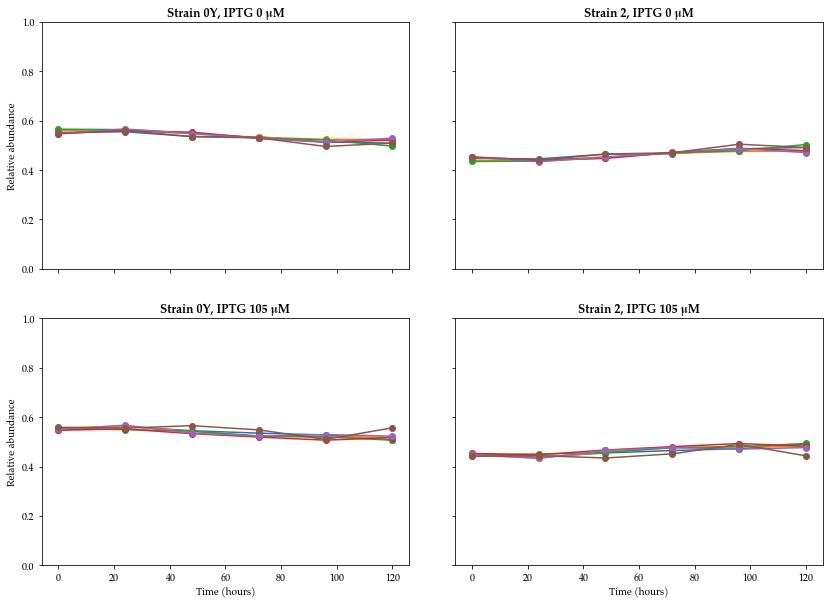

In [55]:
#Plots Figure S.17
fig = plt.figure(figsize=(14,10))
fig.subplots_adjust(hspace=0.2, wspace=0.125)

subplot = fig.add_subplot(2, 2, 0+1)
subplot.set_ylim(0,1)
subplot.plot(measure_times,relab_4_0Y_0IPTG, marker='o')
subplot.set_xlabel('Time (hours)')
subplot.set_ylabel('Relative abundance')
subplot.set_title('Strain 0Y, IPTG 0 μM', fontweight='bold')
subplot.label_outer()

subplot = fig.add_subplot(2, 2, 1+1)
subplot.set_ylim(0,1)
subplot.plot(measure_times,relab_4_2_0IPTG, marker='o')
subplot.set_xlabel('Time (hours)')
subplot.set_ylabel('Relative abundance')
subplot.set_title('Strain 2, IPTG 0 μM', fontweight='bold')
subplot.label_outer()

subplot = fig.add_subplot(2, 2, 2+1)
subplot.set_ylim(0,1)
subplot.plot(measure_times,relab_4_0Y_105IPTG, marker='o')
subplot.set_xlabel('Time (hours)')
subplot.set_ylabel('Relative abundance')
subplot.set_title('Strain 0Y, IPTG 105 μM', fontweight='bold')
subplot.label_outer()

subplot = fig.add_subplot(2, 2, 3+1)
subplot.set_ylim(0,1)
subplot.plot(measure_times,relab_4_2_105IPTG, marker='o')
subplot.set_xlabel('Time (hours)')
subplot.set_ylabel('Relative abundance')
subplot.set_title('Strain 2, IPTG 105 μM', fontweight='bold')
subplot.label_outer()


plt.show()

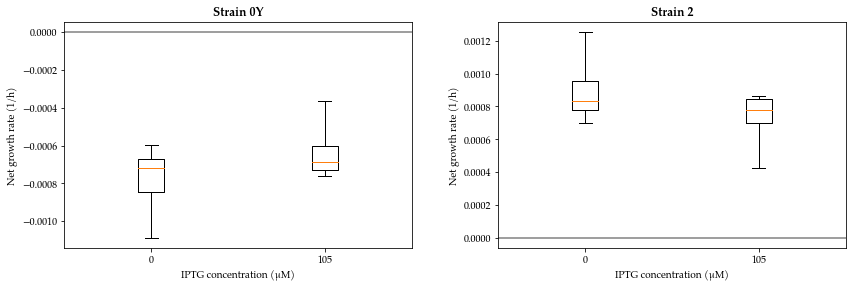

In [56]:
#Plots FIgure S.18
fig = plt.figure(figsize=(14,10))
fig.subplots_adjust(hspace=0.4, wspace=0.25)

subplot = fig.add_subplot(2, 2, 0+1)
subplot.boxplot([growth_rates_4_0Y_0IPTG,growth_rates_4_0Y_105IPTG],whis=[0,100])
subplot.set_title('Strain 0Y', fontweight='bold')
subplot.set_xlabel('IPTG concentration (μM)')
subplot.set_ylabel('Net growth rate (1/h)')
subplot.set_xticks([1,2])
subplot.set_xticklabels(['0','105'])
subplot.axhline(0,color='k',alpha=0.5)



subplot = fig.add_subplot(2, 2, 1+1)
subplot.boxplot([growth_rates_4_2_0IPTG,growth_rates_4_2_105IPTG],whis=[0,100])
subplot.set_title('Strain 2', fontweight='bold')
subplot.set_ylabel('Net growth rate (1/h)')
subplot.set_xlabel('IPTG concentration (μM)')
subplot.set_xticks([1,2])
subplot.set_xticklabels(['0','105'])
subplot.axhline(0,color='k',alpha=0.5)

plt.show()

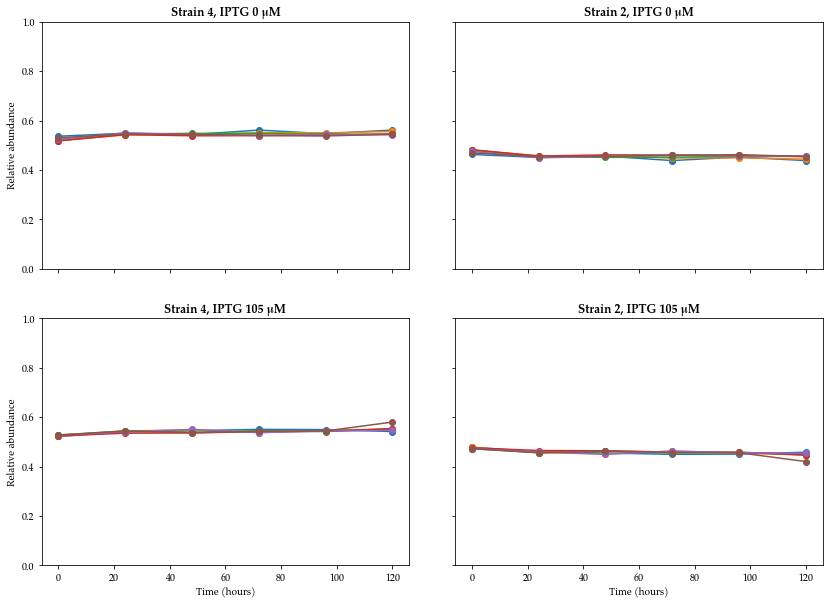

In [57]:
#Plots Figure S.19
fig = plt.figure(figsize=(14,10))
fig.subplots_adjust(hspace=0.2, wspace=0.125)

subplot = fig.add_subplot(2, 2, 0+1)
subplot.set_ylim(0,1)
subplot.plot(measure_times,relab_2_4_0IPTG,marker='o')
subplot.set_xlabel('Time (hours)')
subplot.set_ylabel('Relative abundance')
subplot.set_title('Strain 4, IPTG 0 μM',fontweight='bold')
subplot.label_outer()

subplot = fig.add_subplot(2, 2, 1+1)
subplot.set_ylim(0,1)
subplot.plot(measure_times,relab_2_2_0IPTG,marker='o')
subplot.set_xlabel('Time (hours)')
subplot.set_ylabel('Relative abundance')
subplot.set_title('Strain 2, IPTG 0 μM',fontweight='bold')
subplot.label_outer()

subplot = fig.add_subplot(2, 2, 2+1)
subplot.set_ylim(0,1)
subplot.plot(measure_times,relab_2_4_105IPTG,marker='o')
subplot.set_xlabel('Time (hours)')
subplot.set_ylabel('Relative abundance')
subplot.set_title('Strain 4, IPTG 105 μM',fontweight='bold')
subplot.label_outer()

subplot = fig.add_subplot(2, 2, 3+1)
subplot.set_ylim(0,1)
subplot.plot(measure_times,relab_2_2_105IPTG,marker='o')
subplot.set_xlabel('Time (hours)')
subplot.set_ylabel('Relative abundance')
subplot.set_title('Strain 2, IPTG 105 μM',fontweight='bold')
subplot.label_outer()

plt.show()

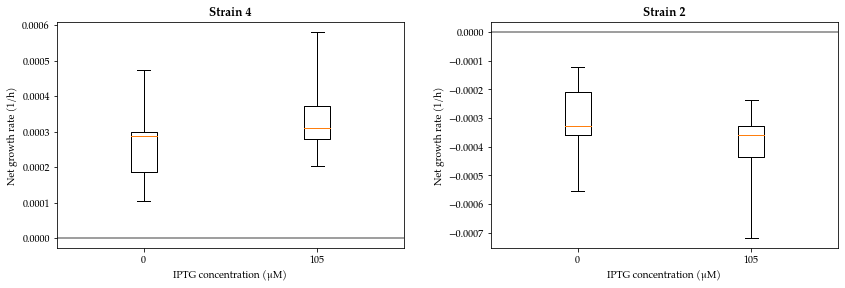

In [58]:
#Plots Figure S.20
fig = plt.figure(figsize=(14,10))
fig.subplots_adjust(hspace=0.4, wspace=0.25)

subplot = fig.add_subplot(2, 2, 0+1)
subplot.boxplot([growth_rates_2_4_0IPTG,growth_rates_2_4_105IPTG],whis=[0,100])
subplot.set_title('Strain 4',fontweight='bold')
subplot.set_xlabel('IPTG concentration (μM)')
subplot.set_ylabel('Net growth rate (1/h)')
subplot.set_xticks([1,2])
subplot.set_xticklabels(['0','105'])
subplot.axhline(0,color='k',alpha=0.5)

subplot = fig.add_subplot(2, 2, 1+1)
subplot.boxplot([growth_rates_2_2_0IPTG,growth_rates_2_2_105IPTG],whis=[0,100])
subplot.set_title('Strain 2',fontweight='bold')
subplot.set_xlabel('IPTG concentration (μM)')
subplot.set_ylabel('Net growth rate (1/h)')
subplot.set_xticks([1,2])
subplot.set_xticklabels(['0','105'])
subplot.axhline(0,color='k',alpha=0.5)

plt.show()